## I. Introduction

In [1]:
import pandas as pd
import numpy as np
import ast

import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectPercentile, chi2, RFE, RFECV, SelectKBest, mutual_info_classif
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.utils import resample


import scipy.stats as stats
from scipy.stats import chi2_contingency, pointbiserialr

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pip install -U scikit-learn

In [3]:
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', None)

In [4]:
train_data = pd.read_csv("datasets/train.csv")
#pd.set_option('display.max_columns', None)
#train_data.head()
train = train_data.copy()
#train = train_df.sample(n=7000, replace=False, random_state=42)

In [5]:
test_data = pd.read_csv("datasets/test.csv")
test = test_data.copy()

# II. Data Exploration and Preprocessing


## II.I Exploratory Data Analysis (EDA)

In [6]:
def data_report(df):
    '''
    Returns a custom DataFrame with information about the input pandas DataFrame.
    
    Args:
        data (pandas DataFrame): Data to analyze.
        
    Returns:
        pandas DataFrame: general information about the DataFrame.
    '''
    print(f'Data size is: {df.shape}')
    print(f'Number of absolute duplicates: {df.duplicated().sum()}')

    data_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'Column type'})
    data_info = data_info.append(pd.DataFrame(df.isna().sum() / len(df) * 100).T.rename(index={0: 'Missing values (%)'}))
    data_info = data_info.append(pd.DataFrame(df.isna().sum()).T.rename(index={0: 'Missing values (abs)'}))
    describe_stat = df.describe().T
    data_info = data_info.T.join(describe_stat)
    data_info['Missing values (%)'] = data_info['Missing values (%)'].apply(lambda x: f'{x:.2f}%')
    data_info = data_info.fillna('-----')
    return data_info

In [7]:
report = data_report(train)
display(report)

Data size is: (71236, 31)
Number of absolute duplicates: 0


,Column type,Missing values (%),Missing values (abs),count,mean,std,min,25%,50%,75%,max
encounter_id,int64,0.00%,0,71236.0,548798.623716,259704.723154,100000.0,323118.5,548370.0,774058.5,999980.0
country,object,0.00%,0,-----,-----,-----,-----,-----,-----,-----,-----
patient_id,int64,0.00%,0,71236.0,54302279.330984,38795850.347332,135.0,23396510.25,45305631.0,87558374.25,189502619.0
race,object,4.99%,3554,-----,-----,-----,-----,-----,-----,-----,-----
gender,object,0.00%,0,-----,-----,-----,-----,-----,-----,-----,-----
age,object,4.99%,3557,-----,-----,-----,-----,-----,-----,-----,-----
weight,object,0.00%,0,-----,-----,-----,-----,-----,-----,-----,-----
payer_code,object,0.00%,0,-----,-----,-----,-----,-----,-----,-----,-----
outpatient_visits_in_previous_year,int64,0.00%,0,71236.0,0.369588,1.287469,0.0,0.0,0.0,0.0,42.0
emergency_visits_in_previous_year,int64,0.00%,0,71236.0,0.196249,0.910854,0.0,0.0,0.0,0.0,76.0


Categorical data statistics

In [8]:
train.describe(include='O').T

,count,unique,top,freq
country,71236,1,USA,71236
race,67682,6,Caucasian,50693
gender,71236,3,Female,38228
age,67679,10,[70-80),17359
weight,71236,10,?,68990
payer_code,71236,18,?,28201
admission_type,67530,7,Emergency,37742
medical_specialty,71236,69,?,34922
discharge_disposition,68646,25,Discharged to home,42256
admission_source,66518,16,Emergency Room,40319


Proportion of patients that have many encounters 

In [9]:
unique_ids_many_enc = (train.groupby('patient_id')['encounter_id'].count() > 1).sum()
unique_ids = train['patient_id'].nunique()
print("Proportion of patients that have many encounters: {:.0%}".format(unique_ids_many_enc / unique_ids))

Proportion of patients that have many encounters: 20%


### Let's divide our data into quantitative and qualitative (metric and non metric)

In [10]:
# first we will do it with select_dtypes
metric = [col for col in train.select_dtypes('int64').columns]
non_metric = [col for col in train.select_dtypes('object').columns]
print(len(non_metric) + len(metric))

31


### Quantitative Data Disualization and Analysis

In [11]:
tmp_metric = train[list(set(metric) - set(['encounter_id', 'patient_id'])) + ['readmitted_binary']]
tmp_metric.head()

,average_pulse_bpm,number_lab_tests,length_of_stay_in_hospital,inpatient_visits_in_previous_year,emergency_visits_in_previous_year,non_lab_procedures,outpatient_visits_in_previous_year,number_diagnoses,number_of_medications,readmitted_binary
0,127,48,2,2,0,0,0,8,20,No
1,128,71,14,0,0,0,0,9,25,No
2,94,60,6,1,0,1,0,6,22,No
3,81,48,6,1,0,2,0,5,9,No
4,126,47,6,0,0,1,1,9,15,No


In [12]:
#sns.pairplot(tmp_metric, diag_kind = 'kde', hue="readmitted_binary", markers=["o", "s"], corner=True)

Distribution of quantitative data

In [14]:
def dist_numeric_features(data, metric_features):
    '''
    Creates distplots for numeric features in the input pandas DataFrame.
    
    Args:
        data (pandas DataFrame): Data to visualize
    
    Returns:
        None
    '''
    # Set up subplots based on the number of numeric features
    num_plots = len(metric_features)
    num_cols = 3 
    num_rows = (num_plots - 1) // num_cols + 1

    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    fig.suptitle('Distribution Plots for Numeric Features', y=1.02)

    axes = axes.flatten()

    # Plot distplots for each numeric feature
    for i, col in enumerate(metric_features):
        sns.histplot(data[col], bins=30, kde=True, ax=axes[i], linewidth=0.2, line_kws={'lw': 0.7}, kde_kws={'bw_adjust': 3})
        axes[i].set_title(col)
        axes[i].lines[0].set_color('crimson')

    plt.tight_layout()
    plt.show()

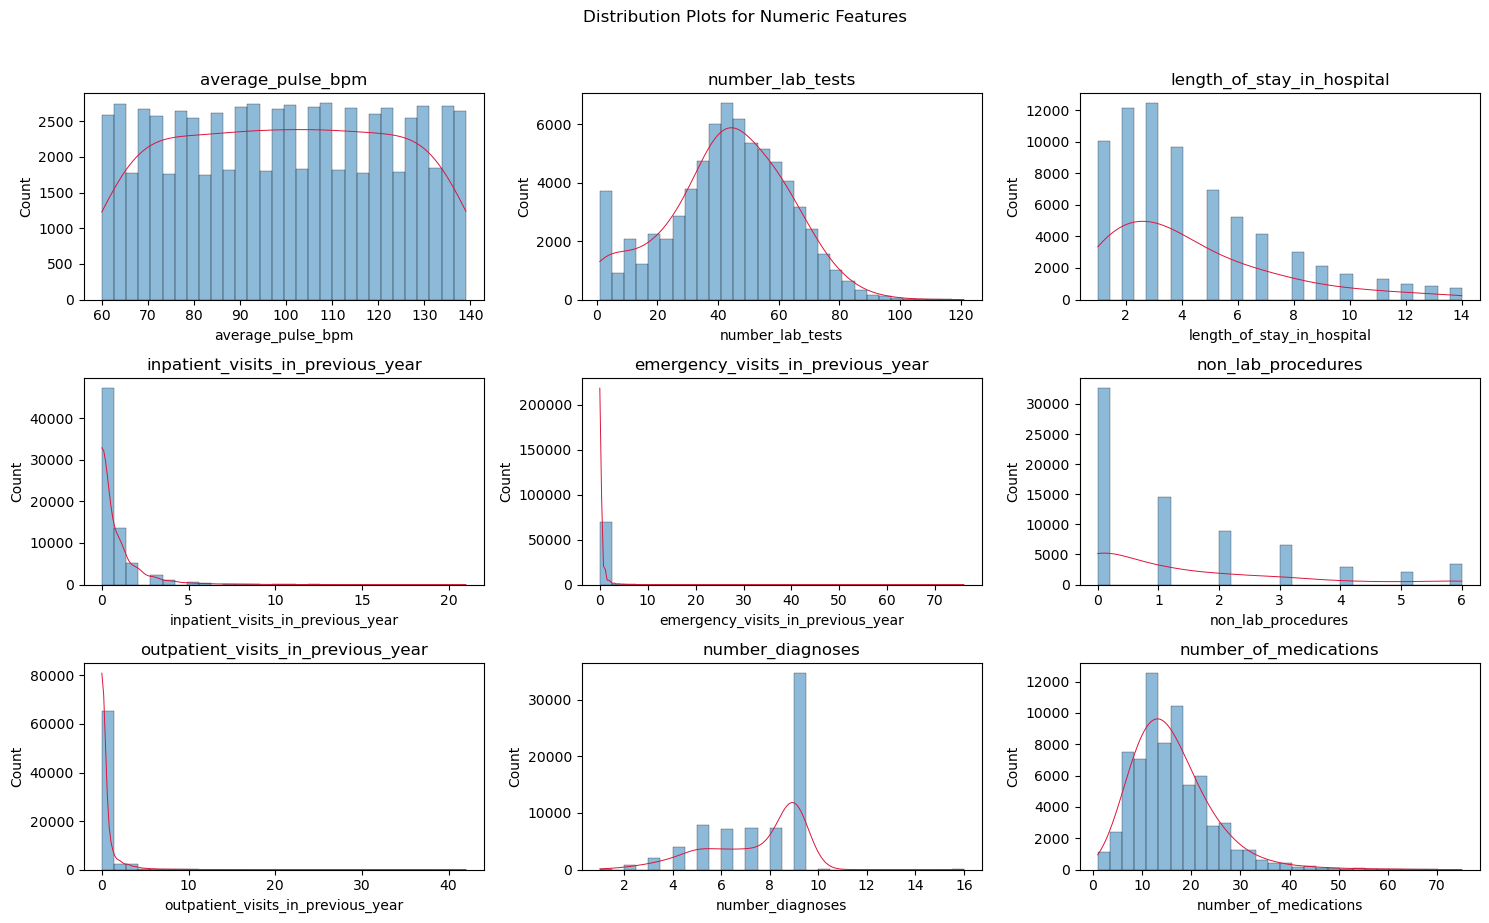

In [15]:
dist_numeric_features(tmp_metric, tmp_metric.columns.drop('readmitted_binary'))

**Findings**

### Qualitative Data Visualization

In [16]:
def count_non_metric(data, non_metric_features):
    
    fig, ax = plt.subplots(len(non_metric_features), 1, figsize = (5, len(non_metric_features)*4)) 

    for i in range(len(non_metric_features)): 
        sns.countplot(data = data,
                      y = data[non_metric_features[i]],
                      hue="readmitted_binary",
                      palette="rainbow",
                      ax = ax[i])
    # Customize
    
    if i == 0:
        ax[i].legend(title='', loc='lower right', labels=['Not readmitted','Readmitted'],  prop={'size': 10})
    else:
        ax[i].legend(title='', loc=0, labels=['Not readmitted','Readmitted'],  prop={'size': 10})
    ax[i].set_ylabel(non_metric_features[i].replace('_', ' '), fontsize=12)
    ax[i].tick_params(axis='y', labelsize=12)
    

    
    # Layout
    fig.suptitle('Count Plots for Categorical Features in Regard to Target', fontsize = 15, y=1.02)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.95, wspace=0.4, hspace=None) 
    plt.show()

In [17]:
low_card = [col for col, rows in train[non_metric].items() if len(rows.value_counts()) <= 10]
low_card.remove("readmitted_binary")
low_card.remove("readmitted_multiclass")

In [18]:
tmp_non_metric = train[non_metric]
tmp_non_metric.age.value_counts()

[70-80)     17359
[60-70)     14908
[80-90)     11510
[50-60)     11423
[40-50)      6418
[30-40)      2536
[90-100)     1875
[20-30)      1071
[10-20)       474
[0-10)        105
Name: age, dtype: int64

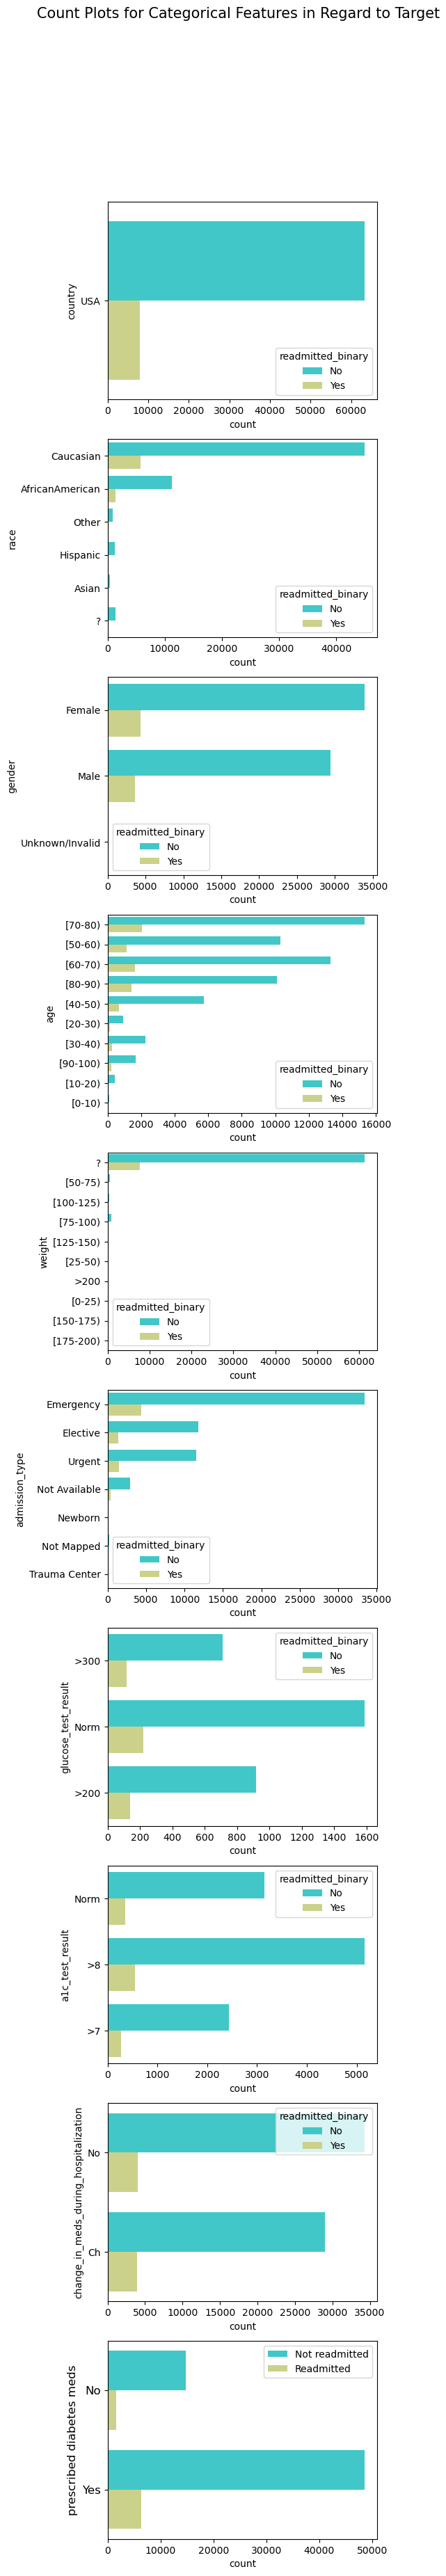

In [19]:
count_non_metric(tmp_non_metric, low_card)

**Findings**

## II.II Extra Block of Analysis

Some proportion of patients (~20%) has more than 1 encounter. Taking this into consideration we can try get some insights into how the encounter_ids
are organized, if there is any pattern that can contribute to making our predictions more accurate.

Moreover, we assume that encounter_ids aren't assigned randomly in the hospitals. 

This extra block consists of the following parts:
 - unite train and test datasets to get a big picture on our encounter_ids;
 - calculate 'distances' to the next and previous encounters if a patient has any, assuming that there might be a time component;
 - calculate number of encounters per patient;
 - plot histograms of distance to next encounters using multiclass labels in order to better understand our potential new feature based on encounter_id.

We will write a function that does all the things mentioned above and apply it to both united dataset and train, 
and for training process we will only use data obtained on train. 

In [20]:
all = pd.concat([train, test])
all.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharge_disposition,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,2,Emergency,Family/GeneralPractice,127,Discharged to home,Emergency Room,2,48,0,20,515,276,466,8,NaN,NaN,No,No,[],No,>30 days
1,426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,0,Emergency,?,128,Discharged/transferred to a federal health car...,Clinic Referral,14,71,0,25,38,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
2,634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,1,NaN,Family/GeneralPractice,94,Discharged to home,NaN,6,60,1,22,534,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
3,890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,1,Emergency,InternalMedicine,81,Discharged to home,Transfer from another health care facility,6,48,2,9,569,562,455,5,NaN,NaN,No,No,[],No,No
4,654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,0,Elective,?,126,Discharged/transferred to home with home healt...,Physician Referral,6,47,1,15,715,599,428,9,NaN,NaN,No,No,[],No,>30 days


In [21]:
all['encounter_id'].sort_values(ascending=True)

40949    100000
63482    100020
51891    100022
17290    100060
55963    100076
          ...  
6240     999944
9228     999953
52932    999966
12147    999968
43724    999980
Name: encounter_id, Length: 101766, dtype: int64

all encounter_ids are in range between 100011 to 999979

In [22]:
def decode_encounters(df_in, module=None):
    '''
    Decodes pattern in encounter_ids via calculating 'distance'
    to either next encounter or previous one
    
    Args:
        df (pd.DataFrame): data to work with 
    
    Returns:
        pd.DataFrame with new features
    '''
    df = df_in.copy()
    df['encounters'] = df.groupby('patient_id')['encounter_id'].transform(lambda x : [list(x)] * len(x))

    def t_e(e):
        return e % module if module else e

    def p_e(e):
        return e // module if module else 0

    df['t_e'] = df.apply(lambda r: t_e(r['encounter_id']), axis=1)
    df['p_e'] = df.apply(lambda r: p_e(r['encounter_id']), axis=1)
    df['num_encounters'] = df.apply(lambda r: len(r['encounters']), axis=1)

    df['next_enc_dist'] = df.apply(
        lambda r: min([t_e(x) for x in r['encounters'] if t_e(x) > r['t_e']], default=np.nan) - r['t_e'],
        axis=1)

    df['prev_enc_dist'] = df.apply(
        lambda r: abs(max([t_e(x) for x in r['encounters'] if t_e(x) < r['t_e']], default=np.nan) - r['t_e']),
        axis=1)
    
    df['encounters'] = df['encounters'].apply(lambda l: str(l))
    return df

In [39]:
def enc_distance_viz(df, dist_col):
    '''
    Visualises 'distance' to either next encounter or previous one
    
    Args:
        df (pandas DataFrame): dataset
        dist_col (pd.Series): distance column
    
    Returns:
        None
    '''
    t300 = df[(df['readmitted_multiclass'] == '>30 days') & (df[dist_col] > 0)]
    t30 = df[(df['readmitted_multiclass'] == '<30 days') & (df[dist_col] > 0)]
    tNo = df[(df['readmitted_multiclass'] == 'No') & (df[dist_col] > 0)]
    print(len(t300), len(t30), len(tNo))

    plt.figure(figsize=(8, 5))
    sns.histplot(data=t300[dist_col], bins=1000, color='blue', label='>30')
    sns.histplot(data=t30[dist_col], bins=1000, color='orange', label='<30')
    sns.histplot(data=tNo[dist_col], bins=1000, color='green', label='No')
    
    plt.title(f"{dist_col} distribution: >30 days, <30 days , No Readmission")
    plt.ticklabel_format(style='plain', axis='x')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(data=t300['t_e'], bins=1000, color='blue', label='>30')
    sns.histplot(data=t30['t_e'], bins=1000, color='orange', label='<30')
    sns.histplot(data=tNo['t_e'], bins=1000, color='green', label='No')
    
    plt.title("Extracted time component distribution: >30 days, <30 days , No Readmission")
    plt.ticklabel_format(style='plain', axis='x')
    plt.legend()
    plt.show()

In [24]:
all_no_mod = decode_encounters(all)
#train_no_mod = decode_encounters(train)

12422 4721 4079


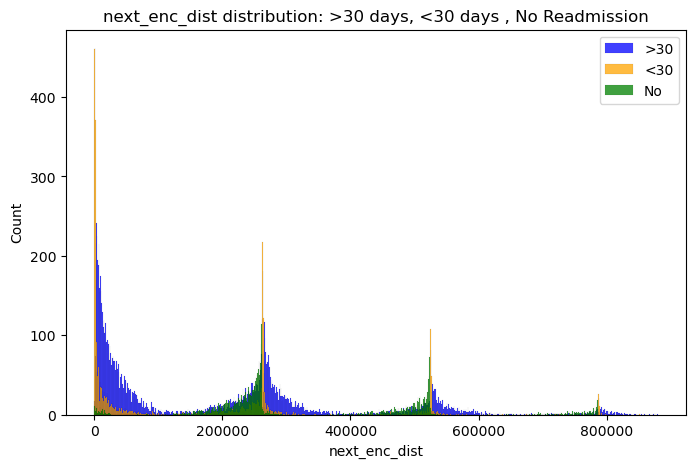

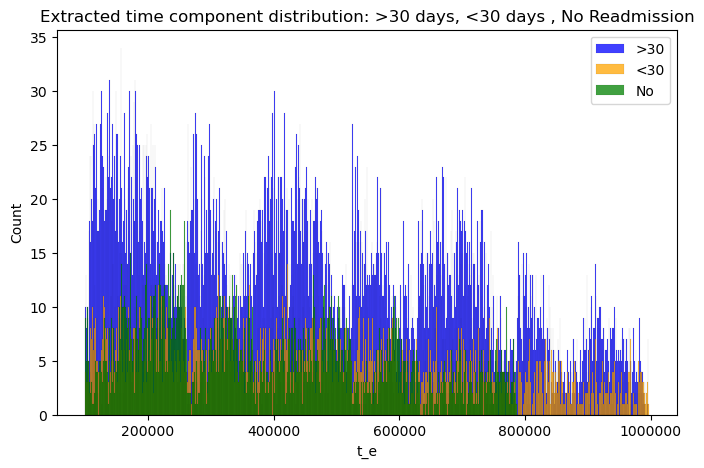

In [40]:
enc_distance_viz(all_no_mod, 'next_enc_dist')
#enc_distance_viz(train_no_mod, 'next_enc_dist')

Both on united dataset and train using distance to the next encounter we can observe 4 peaks. They are too obvious to consider them artifacts. 
So at first the probability density that the person will be readmitted drops with 'distance' passing after discharge. That makes a lot of common sense. But later it starts growing again. And these peaks have a periodic pattern. 
One hypothesis is that it may be connected with annual periodicy of some diseases (infectious or winter traumas). But the distribution of medical speciality and diagnoses of patients "around the peaks" doesn't support it. Also we can try to deduce the ratio between distances in encounters_id and time by looking on humps borders of the classes of patients readmitted in first 30 days and after first 30 days. Then 1 month will correspond to around 2700 points of the encounter_id distance. But then 1 year is about 32000, while the distance beetween peaks is about 260000. It is also very suspicious, that the period beetween peaks is not just around the same, but totally the same. Finaly, it is suprising that we do see distances to the next encounter for the patients from the class of not readdmitted. And, moreover, they group around the peaks, but only from the rising side.
So, there should be another explanation. The period beetween peaks is around 262000, it suspiciously resembles 2**18. So lets'c check, what if first 18 bits of encounter_id are monotonically increased with more or less the same speed corresponding to the time of admission. But the meaning of 2 highest bits is unclear.

In [43]:
all_mod = decode_encounters(all, 2**18)
train_mod = decode_encounters(train, 2**18)

15140 5692 343


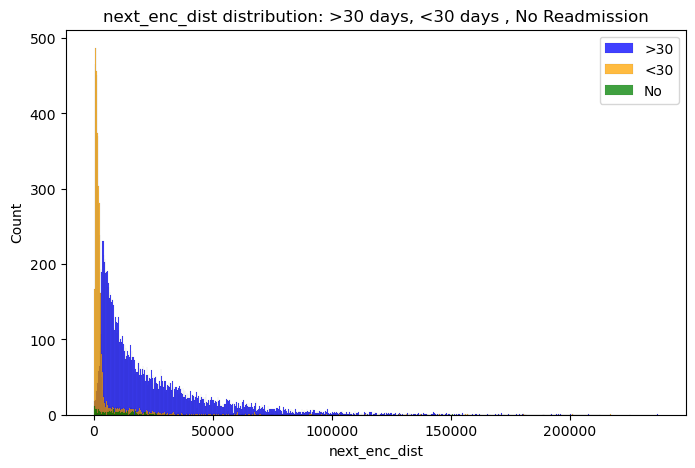

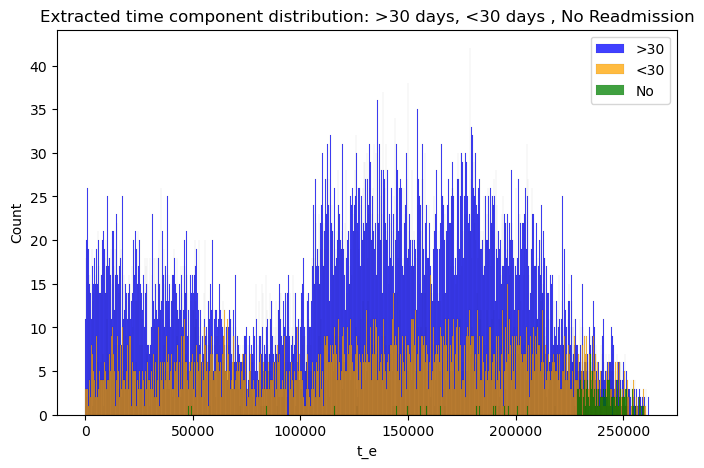

In [41]:
enc_distance_viz(all_mod, 'next_enc_dist')
#enc_distance_viz(train_mod, 'next_enc_dist')

## II.III Preprocessing

This part we will divide into 2 major parts:
- Soft (mininmal) preprocessing
- Hard preprocessing with feature engineering 

#### II.III.I Soft Preprocessing

**Outliers**

In [44]:
train_mod[metric]

,encounter_id,patient_id,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses
0,533253,70110,0,0,2,127,2,48,0,20,8
1,426224,29775006,0,0,0,128,14,71,0,25,9
2,634063,80729253,0,0,1,94,6,60,1,22,6
3,890610,2919042,0,0,1,81,6,48,2,9,5
4,654194,84871971,1,0,0,126,6,47,1,15,9
...,...,...,...,...,...,...,...,...,...,...,...
71231,660160,24531381,0,1,0,90,7,51,1,18,9
71232,826429,4663818,0,0,0,98,9,20,0,9,6
71233,332030,23397147,0,2,2,137,5,25,0,24,9
71234,757560,52161750,0,0,2,123,2,34,1,13,5


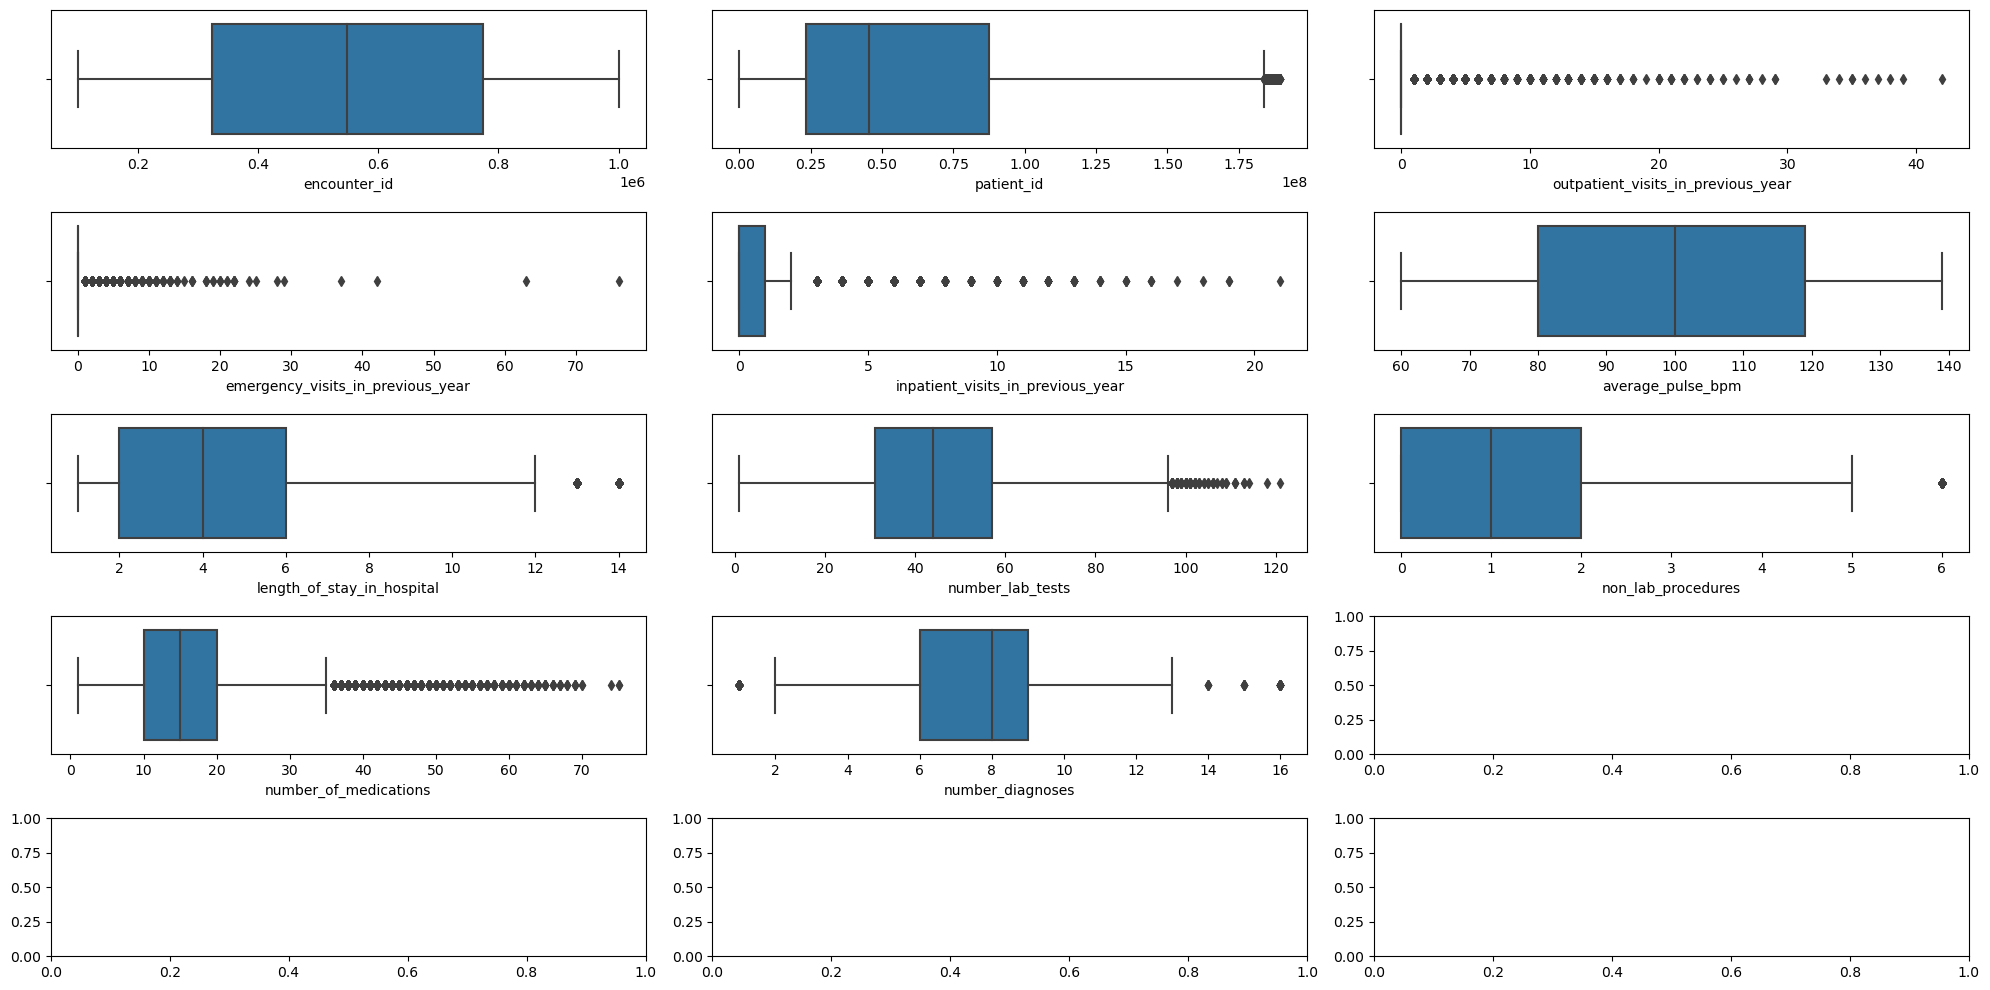

In [45]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(metric):
    sns.boxplot(x=train_mod[col], data=train_mod, ax=axes[i])

plt.tight_layout()
plt.show()

In [46]:
def filters(df):
    filters1 = (
        (df['outpatient_visits_in_previous_year'] <= 30)
        &
        (df['emergency_visits_in_previous_year'] <= 27)
        &
        (df['length_of_stay_in_hospital'] <= 12)
        &
        (df['number_lab_tests'] <= 95)
        &
        (df['number_of_medications'] <= 40)
        &
        (df['number_diagnoses'] < 14)
    )
    return df[filters1]

train_mod = filters(train_mod)
train_mod.shape

(68685, 37)

We don't need to delete all the outliers. We will apply log transformation to get rid of very extreme values

In [49]:
# identifying missing values in different forms
def missing_values_to_nan(df, values):
    '''
    Finds missing values represented by chars / strings

    Args:
        df (pd.DataFrame): dataset
        values (list): list of symbols or strings that may represent missing values

    Returns:
        pd.Dataframe
    '''
    columns_miss = df.columns[df.isin(values).any()]
    df[columns_miss] = df[df.columns[df.isin(values).any()]].replace(values, np.nan)
    return df


In [50]:
# 'race' - that is what don't change within life, so we can fill missing 'race' values for the same patient if there are any. 
def fillna_race(df):
    col = "race"
    df.loc[df[col].isna(), col] = df.groupby(['patient_id'])[col].transform(
                lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    return df

The initial idea was to come up with a new category 'missing' in the following categorical columns:
**"race", "payer_code", "admission_type", "medical_specialty", "admission_source", "discharge_disposition"**.
We will do it in our research, but later. The reason is that we would like to compare **'simple' algorithms and 'complicated' ones**,
that are able to cope with missing values natively. 



We will write simple mapping functions for 
**"age", "change_in_meds_during_hospitalization",  "prescribed_diabetes_meds", "readmitted_binary", "readmitted_multiclass"**
in order to make algorithms cope with them. 

**Age** decades we will map with ordinal numbers

In [51]:
def mapper(df):            
    df['age'] = df['age'].map(
        {'[0-10)': 0, 
         '[10-20)': 1, 
         '[20-30)': 2, 
         '[30-40)': 3, 
         '[40-50)': 4,
         '[50-60)': 5, 
         '[60-70)': 6, 
         '[70-80)': 7, 
         '[80-90)': 8,
         '[90-100)': 9})
    
    df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].map({'No': 0, 'Ch': 1})
    df['readmitted_multiclass'] = df['readmitted_multiclass'].map({'No': 0, '>30 days': 1, '<30 days': 2})
    df['readmitted_binary'] = df['readmitted_binary'].map({'No': 0, 'Yes': 1})
    df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].map({'No': 0, 'Yes': 1})
    
    return df

**medication**

Medication feature is messy and in order to extract potentially useful information from it,
we should first clean the feature from extra characters and then we can come up with new boolean features if a patient is prescribed with some specific medication or not.

We'll also create a feature with top the most frequent combinations of features in medication column

In [52]:
def medication_t(df, th=100, top_first_combined=240):
    def medication_to_list(df):
        r = df.copy()
        r['medication'] = r['medication'].apply(
            lambda l: sorted(l.replace('[', '').replace(']', '').replace("'", '').replace(' ', '').replace('-', ',').split(',')))
        return r
    
    meds_counter = collections.Counter()
    train_medications = medication_to_list(train)['medication']
    for meds in train_medications:
        for med in meds:
            meds_counter[med] += 1
            
    meds_counter = collections.Counter({k: v for k, v in meds_counter.items() if k and v > th})

    r = medication_to_list(df)
    for med in meds_counter.keys():
        r[med] = r['medication'].apply(lambda l: med in l).astype('int')
            
    train_popular_med_combinations = train_medications.apply(lambda l: ','.join(l)).value_counts()[:top_first_combined]
    
    def combine_meds(meds):
        top = 5
        top_meds = sorted([m[0] for m in meds_counter.most_common(top)])
        result = ','.join(meds)
        if result in train_popular_med_combinations:
            return result
        return ','.join([m for m in meds if m in top_meds])
    
    r['medication'] = r['medication'].apply(combine_meds)
           
    return r, meds_counter.keys()

In [53]:
def soft_preprosessing(df_in):
    df = df_in.copy()
    df = missing_values_to_nan(df, ['?', "None", "nan"])
    df['weight'] = df['weight'].replace(regex={r'^(\[|>)(\d+).*$': '\\2'}).astype(pd.Int64Dtype())
    df['gender'] = df['gender'].map({'Female': False, 'Male': True}).astype(pd.BooleanDtype())
    
    df['glucose_test_result'].replace({'Norm': 0, '>200': 1, '>300': 2}, inplace=True)
    df['a1c_test_result'].replace({'Norm': 0, '>7': 1, '>8': 2}, inplace=True)
    df = fillna_race(df)
    df = mapper(df)
    df, medication_binary_features = medication_t(df, th=100, top_first_combined=-1)
    return df, medication_binary_features
    

#### II.III.II Hard Preprocessing with Feature Engineering

We will move from feature to feature of interest in order to perform different manipulations with them

**payer_code:**
 - Create a new feature describing if a patient has an insurance or not
 - create a new category **"rare"** if the value_counts() of some category is less than 300

In [54]:
def payer_code(df):
    df["has_payer_code"] = np.where(df["payer_code"].isnull(), 0, 1)
    df.loc[df['payer_code'].value_counts(dropna=False)[df['payer_code']].values < 300,'payer_code'] = "rare"
    return df

**primary_diagnosis, secondary_diagnosis,  additional_diagnosis**

**Diagnoses manipulations consist of the following parts:**
- *map diagnoses to their ICD-9 categories to reduce cardinality of diagnoses features*
- *creating new features **diabetes_diagnosis, onco_diagnosis and psycho_diagnosis** assuming they may contribute to readmissions*

We have too many diagnoses in diagnoses features and in order to reduce noise and dimentionality we can group the diagnoses in bigger categories
based on  the official ICD-9 sections 

- List of ICD-9 codes 001–139: infectious and parasitic diseases
- List of ICD-9 codes 140–239: neoplasms
- List of ICD-9 codes 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
- List of ICD-9 codes 280–289: diseases of the blood and blood-forming organs
- List of ICD-9 codes 290–319: mental disorders
- List of ICD-9 codes 320–389: diseases of the nervous system and sense organs
- List of ICD-9 codes 390–459: diseases of the circulatory system
- List of ICD-9 codes 460–519: diseases of the respiratory system
- List of ICD-9 codes 520–579: diseases of the digestive system
- List of ICD-9 codes 580–629: diseases of the genitourinary system
- List of ICD-9 codes 630–679: complications of pregnancy, childbirth, and the puerperium
- List of ICD-9 codes 680–709: diseases of the skin and subcutaneous tissue
- List of ICD-9 codes 710–739: diseases of the musculoskeletal system and connective tissue
- List of ICD-9 codes 740–759: congenital anomalies
- List of ICD-9 codes 760–779: certain conditions originating in the perinatal period
- List of ICD-9 codes 780–799: symptoms, signs, and ill-defined conditions
- List of ICD-9 codes 800–999: injury and poisoning
- List of ICD-9 codes E and V codes: external causes of injury and supplemental classification

In [55]:
def map_icd9_to_groups(icd9_code):
    '''
    Maps diagnoses codes with the related ICD-9 category

    Args:
        icd_9_code: a code from ICD 9
        
    Returns:
        new category value
    '''
    if icd9_code != np.nan:
        icd9_code = str(icd9_code)
        icd9_code = icd9_code.split(".")[0]
    
        try:
            icd9_code = int(icd9_code)  # Try to convert to integer for numeric comparison
        except ValueError:
            # If conversion fails, it's likely an alphanumeric code (e.g., 'V57')
            return 'External Causes of Injury and Supplemental Classification'
    
        if 1 <= icd9_code <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= icd9_code <= 239:
            return 'Neoplasms'
        elif 240 <= icd9_code <= 279:
            return 'Endocrine, Nutritional, and Metabolic Diseases, and Immunity Disorders'
        elif 280 <= icd9_code <= 289:
            return 'Diseases of the Blood and Blood-Forming Organs'
        elif 290 <= icd9_code <= 319:
            return 'Mental Disorders'
        elif 320 <= icd9_code <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= icd9_code <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= icd9_code <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= icd9_code <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= icd9_code <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= icd9_code <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= icd9_code <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= icd9_code <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= icd9_code <= 759:
            return 'Congenital Anomalies'
        elif 760 <= icd9_code <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= icd9_code <= 799:
            return 'Symptoms, Signs, and Ill-Defined Conditions'
        elif 800 <= icd9_code <= 999:
            return 'Injury and Poisoning'
        else:
            return 'Other'
    else:
        return icd9_code
        
def convert_to_int(code):
    try:
        return int(code)
    except ValueError:
        return code

In [94]:
def diagnosis_manipulation(df_in):
    df = df_in.copy()
    diagnoses = ["primary_diagnosis",
                 "secondary_diagnosis",
                 "additional_diagnosis"]
                           
    df["primary_diagnosis_grouped"] = df["primary_diagnosis"].apply(map_icd9_to_groups)
    df["secondary_diagnosis_grouped"] = df["secondary_diagnosis"].apply(map_icd9_to_groups)
    df["additional_diagnosis_grouped"] = df["additional_diagnosis"].apply(map_icd9_to_groups)

    # converting diagnosis codes to int to be able to find ranges 
    df["primary_diagnosis"] = df["primary_diagnosis"].apply(convert_to_int)
    df["secondary_diagnosis"] = df["primary_diagnosis"].apply(convert_to_int)
    df["additional_diagnosis"] = df["primary_diagnosis"].apply(convert_to_int)

    # creating a feature if a patient has a diabetes diagnosis or not
    df["diabetes_diagnosis"] = df[diagnoses].isin([250]).any(axis=1).astype('int')

    # according to ICD-9 malignant neoplasms have codes 140-209
    df["onco_diagnosis"] = df[diagnoses].isin(range(140,210)).any(axis=1).astype('int')
    
    df["primary_diagnosis"] = df["primary_diagnosis"].apply(str)
    df["secondary_diagnosis"] = df["primary_diagnosis"].apply(str)
    df["additional_diagnosis"] = df["primary_diagnosis"].apply(str)
    
    # creating a feature indicating if a patient has mental disorder or not
    df["psycho_diagnosis"] = df[["primary_diagnosis_grouped", "secondary_diagnosis_grouped", "additional_diagnosis_grouped"]].isin(['Mental Disorders']).any(axis=1).astype('int')
    return df
    

**admission_type and admission_source**

In both columns we will map 'Not Available' and 'Not Mapped' with np.nan turning them into missing values.
Also we will put all subcategories with value_counts() less than 300 in a new subcategory 'rare'.

In [95]:
def admission(df):
    df['admission_type'].replace({'Not Available': np.nan, 'Not Mapped': np.nan}, inplace=True)
    df["admission_source"] = df["admission_source"].str.strip(" ")
    df["admission_source"].replace({'Not Available': np.nan, 'Not Mapped': np.nan}, inplace=True)
    df.loc[df["admission_source"].value_counts(dropna=False)[df["admission_source"]].values < 300, "admission_source"] = "rare"
    return df

**discharge_disposition**

This feature has high cardinality, i.e. includes many subcategories and some of them are semantically close to each other.
We can perform semantic mapping in order to reduce the number of subcategories.

As we can notice there is a presence of **'expired'** patients in the dataset. They don't have any predictive value in this case, because being 'expired'
automatically means 'not being readmitted'

In [96]:
train_mod["discharge_disposition"].value_counts()

Discharged to home                                                                                           41388
Discharged/transferred to SNF                                                                                 9259
Discharged/transferred to home with home health service                                                       8433
Discharged/transferred to another short term hospital                                                         1442
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1302
Expired                                                                                                       1050
Discharged/transferred to another type of inpatient care institution                                           777
Not Mapped                                                                                                     665
Discharged/transferred to ICF                                                   

In [97]:
def discharge_cats(df):
    df["discharge_disposition"] = df["discharge_disposition"].replace('Not Mapped', np.nan)

    category_mapping = {
    'Discharged to home': 'Home Discharge',
    'Discharged/transferred to SNF': 'Facility Transfer',
    'Discharged/transferred to home with home health service': 'Home Discharge with Health Service',
    'Discharged/transferred to another short term hospital': 'Short Term Facility Transfer',
    'Discharged/transferred to another rehab fac including rehab units of a hospital .': 'Facility Transfer',
    'Expired': 'Expired',
    'Discharged/transferred to another type of inpatient care institution': 'Facility Transfer',
    'Discharged/transferred to ICF': 'Facility Transfer',
    'Left AMA': 'Other',
    'Discharged/transferred to a long term care hospital.': 'Facility Transfer',
    'Hospice / medical facility': 'Hospice',
    'Hospice / home': 'Hospice',
    'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital': 'Facility Transfer',
    'Discharged/transferred to home under care of Home IV provider': 'Home Discharge with Health Service',
    'Discharged/transferred within this institution to Medicare approved swing bed': 'Facility Transfer',
    'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.': 'Facility Transfer',
    'Admitted as an inpatient to this hospital': 'Other',
    'Discharged/transferred/referred to this institution for outpatient services': 'Outpatient Services',
    'Discharged/transferred/referred another institution for outpatient services': 'Outpatient Services',
    'Expired at home. Medicaid only, hospice.': 'Expired',
    'Discharged/transferred to a federal health care facility.': 'Facility Transfer',
    'Neonate discharged to another hospital for neonatal aftercare': 'Facility Transfer',
    'Still patient or expected to return for outpatient services': 'Outpatient Services',
    'Expired in a medical facility. Medicaid only, hospice.': 'Expired'
    }

    # Map the categories to the new categories
    df['discharge_disposition'] = df['discharge_disposition'].map(category_mapping)

    #delete 'expired patients'
    df = df[~df["discharge_disposition"].str.contains('Expired', na=False)].reset_index(drop=True)
    return df

**medical specialty**

This feature is also abundant in subcategories. We'll perform a mapping that puts close subcategories in a bigger ones, 
and also create a subcategory **'rare'** if value_counts() if either subcategory is less than 250


In [98]:
def medical_specialty_mapping(df):
    
    category_mapping = {
    'Family/GeneralPractice': 'Primary Care',
    'missing': 'missing',
    'InternalMedicine': 'Internal Medicine',
    'Surgery-General': 'Surgery',
    'Radiologist': 'Radiology',
    'Emergency/Trauma': 'Emergency Medicine',
    'Hematology': 'Hematology',
    'Nephrology': 'Nephrology',
    'Orthopedics': 'Orthopedics',
    'ObstetricsandGynecology': 'Obstetrics and Gynecology',
    'Psychiatry': 'Psychiatry',
    'Cardiology': 'Cardiology',
    'Gastroenterology': 'Gastroenterology',
    'Psychology': 'Psychology',
    'Surgery-Thoracic': 'Surgery',
    'Orthopedics-Reconstructive': 'Orthopedics',
    'Surgery-Vascular': 'Surgery',
    'PhysicianNotFound': 'Other',
    'Neurology': 'Neurology',
    'PhysicalMedicineandRehabilitation': 'Rehabilitation',
    'Pulmonology': 'Pulmonology',
    'Hematology/Oncology': 'Oncology',
    'Oncology': 'Oncology',
    'Surgery-Neuro': 'Surgery',
    'Radiology': 'Radiology',
    'Urology': 'Urology',
    'Pediatrics': 'Pediatrics',
    'Surgery-Cardiovascular/Thoracic': 'Surgery',
    'Gynecology': 'Obstetrics and Gynecology',
    'Pediatrics-Endocrinology': 'Pediatrics',
    'Surgery-Maxillofacial': 'Surgery',
    'Podiatry': 'Podiatry',
    'Ophthalmology': 'Ophthalmology',
    'Endocrinology': 'Endocrinology',
    'Obstetrics': 'Obstetrics and Gynecology',
    'Pediatrics-CriticalCare': 'Pediatrics',
    'Otolaryngology': 'Otolaryngology',
    'Pediatrics-Neurology': 'Pediatrics',
    'Surgery-Cardiovascular': 'Surgery',
    'Hospitalist': 'Internal Medicine',
    'Surgery-Plastic': 'Surgery',
    'Osteopath': 'Other',
    'Pediatrics-Pulmonology': 'Pediatrics',
    'SurgicalSpecialty': 'Surgery',
    'InfectiousDiseases': 'Infectious Diseases',
    'AllergyandImmunology': 'Other',
    'Surgeon': 'Surgery',
    'DCPTEAM': 'Other',
    'Anesthesiology-Pediatric': 'Anesthesiology',
    'Obsterics&Gynecology-GynecologicOnco': 'Obstetrics and Gynecology',
    'Surgery-Colon&Rectal': 'Surgery',
    'Pathology': 'Other',
    'Rheumatology': 'Rheumatology',
    'Anesthesiology': 'Anesthesiology',
    'Pediatrics-EmergencyMedicine': 'Pediatrics',
    'Cardiology-Pediatric': 'Cardiology',
    'Psychiatry-Child/Adolescent': 'Psychiatry',
    'Dentistry': 'Other',
    'OutreachServices': 'Other',
    'Speech': 'Other',
    'Pediatrics-AllergyandImmunology': 'Pediatrics',
    'Surgery-Pediatric': 'Surgery',
    'Pediatrics-Hematology-Oncology': 'Pediatrics',
    'Endocrinology-Metabolism': 'Endocrinology',
    'SportsMedicine': 'Other',
    'Pediatrics-InfectiousDiseases': 'Pediatrics',
    'Proctology': 'Other',
    'Resident': 'Other',
    'Neurophysiology': 'Neurology'
}


    df['medical_specialty'] = df['medical_specialty'].map(category_mapping)

    # create a new subcategory 'rare'
    df.loc[df["medical_specialty"].value_counts(dropna=False)[df["medical_specialty"]].values < 250,"medical_specialty"] = "rare"
    return df

We'll create a new feature **total visits** that is the result of summ of **outpatient_visits_in_previous_year, emergency_visits_in_previous_year, inpatient_visits_in_previous_year**

In [99]:
def total_visits(df):
    df["total_visits"] = 0
    cols = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year','inpatient_visits_in_previous_year']
    for col in cols:
        df["total_visits"] += df[col]
    return df

We'll add soft preprocessing functions to our hard preprocessing function.

In [100]:
def hard_preprocessing(df_in):
    df = df_in.copy()
    df = missing_values_to_nan(df, ['?', "None", "nan"])
    df['weight'] = df['weight'].replace(regex={r'^(\[|>)(\d+).*$': '\\2'}).astype(pd.Int64Dtype())
    df['gender'] = df['gender'].map({'Female': False, 'Male': True}).astype(pd.BooleanDtype())
        
    df['glucose_test_result'].replace({'Norm': 0, '>200': 1, '>300': 2}, inplace=True)
    df['a1c_test_result'].replace({'Norm': 0, '>7': 1, '>8': 2}, inplace=True)
    df = fillna_race(df)
    df = mapper(df)
    df = payer_code(df)
    df = diagnosis_manipulation(df)
    df, medication_binary_features = medication_t(df)
    df = admission(df)
    df = discharge_cats(df)
    df = medical_specialty_mapping(df)
    df = total_visits(df)
    return df, medication_binary_features

In [101]:
# First let's separate features and targets 
df_for_scaling, _ = hard_preprocessing(train_mod)
features = df_for_scaling.drop(columns=['readmitted_binary', 'readmitted_multiclass', 'num_encounters', 'next_enc_dist'])
target_binary = df_for_scaling['readmitted_binary']

In [102]:
def scale_get_result(X_train, X_test, y_train, y_test, scaler):
    X_tr, X_t, y_tr, y_t = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
    sc = scaler.fit(X_tr)
    train_X_scaled = sc.transform(X_tr)
    test_X_scaled = sc.transform(X_t)
    model_sc = LogisticRegression(random_state=42, class_weight="balanced").fit(train_X_scaled, y_tr)
    return f1_score(y_t, model_sc.predict(test_X_scaled))
    

def best_scaler(X, y): 
    metric = [col for col in X.select_dtypes('int64').columns]
    X_num = X[metric]
    X_train, X_test, y_train, y_test = train_test_split(X_num, y, stratify=y, test_size=0.33, random_state=42)
    scaler_labels = ['Raw', 'RobustScaler', 'MinMaxScaler', 'MinMaxScaler[-1, 1]']

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit(X_train)
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    
    robust_sc = RobustScaler()
    min_max_sc = MinMaxScaler()
    min_max_sc_range = MinMaxScaler(feature_range = (-1, 1))

    results = []
    
    lr_raw = LogisticRegression(random_state=42, class_weight="balanced").fit(X_train, y_train)
    results.append(f1_score(y_test, lr_raw.predict(X_test)))

    for scaler in [robust_sc, min_max_sc, min_max_sc_range]:
        result = scale_get_result(X_train, X_test, y_train, y_test, scaler)
        results.append(result)

    # Plot  
    df_sc = pd.DataFrame({'scalers': scaler_labels,
                         'f1': results})
                         
    plt.figure(figsize = (8,5))
    bars = plt.bar(scaler_labels, results)
    
    # Layout
    plt.title('Comparison of Scalers')
    plt.xticks(fontsize = 10)
    plt.ylim([0,1])

    for bar, result in zip(bars, results):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(result, 2), va='bottom', ha='center', fontsize=10)

    plt.show() 

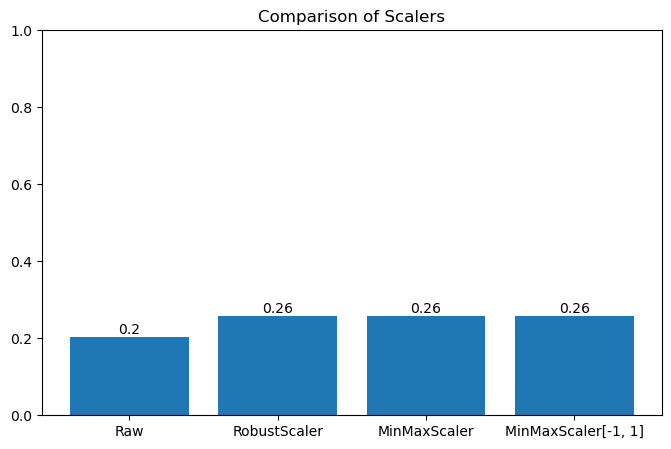

In [103]:
best_scaler(features, target_binary)
del features

#### II.III.IV Feature Selection

To select relevant features and identify redundant ones we will use the following approaches:

- **Filter-Based**:
    This kind of approaches is based on data intristic attributes such as feature correlation/statistics.
    In our case we'll use **Chi-squared test, Spearman rank correlation, point biserial correlation and mutual information**. 
    
- **Wrapper-Based**:
    This family of approaches include assessing the importance of features using specific machine learning algorithms.
    We will use **Recursive Feature Elimination with Crossvalidation (RFECV) with Logistic Regression base estimator.**
- **Embedded**:
    in this approach feature selection process is a part of the learning algorithm.
    We will use **Lasso Regression with Cross-Validation** for our purpose. 

In [104]:
train_hard, _ = hard_preprocessing(train_mod)
X_hard = train_hard.drop(columns=["readmitted_binary", "readmitted_multiclass"])
y_hard = train_hard['readmitted_binary']

In [105]:
metric_features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses',
    't_e',
    'prev_enc_dist',
    'total_visits'
]


cheat_features = [
    'next_enc_dist',
    'num_encounters'
]

semantically_metric_features = [
    "age",
    'weight',
    'glucose_test_result',
    'a1c_test_result'
]

med_binary_features = [
    'insulin',
    'glimepiride',
    'metformin',
    'glipizide',
    'nateglinide',
    'glyburide',
    'rosiglitazone',
    'repaglinide',
    'pioglitazone',
    'acarbose',
    'diabetes_diagnosis',
    'onco_diagnosis',
    'psycho_diagnosis'
]

    
binary_features = [
    'gender',
    'change_in_meds_during_hospitalization',
    'prescribed_diabetes_meds',
    'has_payer_code'
]

high_cardinal_categorical_features = [
    'medication',
    'primary_diagnosis',
    'secondary_diagnosis',
    'additional_diagnosis',
]

low_cardinal_categorical_features = [
    'race',
    'payer_code',
    'admission_type',
    'medical_specialty',
    'discharge_disposition',
    'admission_source',
    'p_e',
    'primary_diagnosis_grouped',
    'secondary_diagnosis_grouped',
    'additional_diagnosis_grouped',
]

len(metric_features) + len(cheat_features) + len(semantically_metric_features) + len(med_binary_features) + len(binary_features) + len(low_cardinal_categorical_features) + len(high_cardinal_categorical_features)

49

In [106]:
all_features = metric_features + cheat_features +\
               semantically_metric_features +\
               med_binary_features +\
               binary_features +\
               low_cardinal_categorical_features +\
               high_cardinal_categorical_features

metric_features_all = metric_features +\
                      cheat_features +\
                      semantically_metric_features

non_metric_features = med_binary_features +\
                      binary_features +\
                      low_cardinal_categorical_features +\
                      high_cardinal_categorical_features

len(all_features)

49

In [107]:
def preprocessor_f(metric_features, semantically_metric_features, med_binary_features, cheat_features,
                    binary_features, low_cardinal_categorical_features, high_cardinal_categorical_features, multi=False):
    '''
    Creates preprocessor 
    
    '''
    log_metric_transformer = Pipeline(
        steps=[('inputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
               ('log_transform', FunctionTransformer(np.log1p)),
               ('scaler', MinMaxScaler(feature_range = (-1, 1)))
               ])
    
 
    ordinal_transformer = Pipeline(
        steps=[('encoder', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=np.nan,
            encoded_missing_value=-1,
            max_categories=253))])
    
    if multi == True:
        ordinal_features = low_cardinal_categorical_features + high_cardinal_categorical_features
        
        preprocessor = ColumnTransformer(
        transformers=[
            ("identity", "passthrough", 
             binary_features
             + med_binary_features),
            ("metric", log_metric_transformer, metric_features + semantically_metric_features + cheat_features),
            ("ordinal", ordinal_transformer, ordinal_features)],
        sparse_threshold=0,
        verbose_feature_names_out=False
        )
        
        preprocessor.set_output(transform="pandas")
        return preprocessor

    else:
        
        target_transformer = Pipeline(steps=[('encoder', TargetEncoder())])
        
        ordinal_features = low_cardinal_categorical_features
        target_features = high_cardinal_categorical_features
    
        
        preprocessor = ColumnTransformer(
            transformers=[
                ("identity", "passthrough", 
                 binary_features
                 + med_binary_features),
                ("log_metric", log_metric_transformer, metric_features + semantically_metric_features + cheat_features),
                ("ordinal", ordinal_transformer, ordinal_features),
                ("target", target_transformer, target_features)],
            sparse_threshold=0,
            verbose_feature_names_out=False
        )
        preprocessor.set_output(transform="pandas")
        return preprocessor

In [108]:
features_df = train_hard[all_features]
target_binary = train_hard['readmitted_binary']
prep = preprocessor_f(metric_features, semantically_metric_features, med_binary_features, cheat_features,
                    binary_features, low_cardinal_categorical_features, high_cardinal_categorical_features)
prep.fit(features_df, target_binary)

ColumnTransformer(sparse_threshold=0,
                  transformers=[('identity', 'passthrough',
                                 ['gender',
                                  'change_in_meds_during_hospitalization',
                                  'prescribed_diabetes_meds', 'has_payer_code',
                                  'insulin', 'glimepiride', 'metformin',
                                  'glipizide', 'nateglinide', 'glyburide',
                                  'rosiglitazone', 'repaglinide',
                                  'pioglitazone', 'acarbose',
                                  'diabetes_diagnosis', 'onco_diagnosis',
                                  'psycho_dia...
                                 ['race', 'payer_code', 'admission_type',
                                  'medical_specialty', 'discharge_disposition',
                                  'admission_source', 'p_e',
                                  'primary_diagnosis_grouped',
                                  'secondary_diagnosis_grouped',
                                  'additional_diagnosis_grouped']),
                                ('target',
                                 Pipeline(steps=[('encoder', TargetEncoder())]),
                                 ['medication', 'primary_diagnosis',
                                  'secondary_diagnosis',
                                  'additional_diagnosis'])],
                  verbose_feature_names_out=False)

In [109]:
features_df = prep.transform(features_df)
len(features_df.columns)

49

### Chi-squared

Let's use Chi-square test of independence of variables in a contingency table and according to obtained p-values identify the importance of each categorical feature for the target

In [133]:
def TestIndependence(X, y, var, alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    if p<alpha:
        result="Keep".format(var)
    else:
        result="Discard".format(var)
    return result

def chi_2_selection(X, y, non_metric):
    '''
    Identifies the importance of each categorical feature based on chi-squared test of independence of variables

    Args:
        X (pd.DataFrame): Datatframe containing all the features
        y (pd.Series): Binary target variable
        non_metric: List of all categorical column names 
    
    Returns:
        pd.DataFrame with feature names and whether to keep or discard them
    '''
    results = []
    for var in X[non_metric_features]:
        results.append(TestIndependence(X[var],target_binary, var))
    chi_df = pd.DataFrame({'feature' : non_metric_features,
                           'Chi-Squared' : results})
    chi_df = chi_df.set_index('feature')
    return chi_df

### Spearman Rank Correlation

In [134]:
def spearman_selection(X_num, y, threshold=0.5):
    '''
    Determine which features to keep or discard based on Spearman rank correlation.

    Args:
        X_num (pd.DataFrame): DataFrame containing numeric features.
        y (pd.Series): Binary target variable.
        threshold (float): Correlation coefficient threshold to decide whether to keep a feature.

    Returns:
        pd.DataFrame: DataFrame indicating whether to discard or keep a feature.
    '''
    
    # Calculate Spearman rank correlations
    correlations = X_num.apply(lambda x: x.corr(y, method='spearman'))

    # Determine which features to discard based on the threshold
    to_discard = ['Keep' if abs(corr) >= threshold else 'Discard' for corr in correlations]

    # Create a DataFrame for the result
    result = pd.DataFrame({'feature': X_num.columns, 
                           'Correlation': correlations, 
                           'Spearman': to_discard})

    return result

<AxesSubplot:>

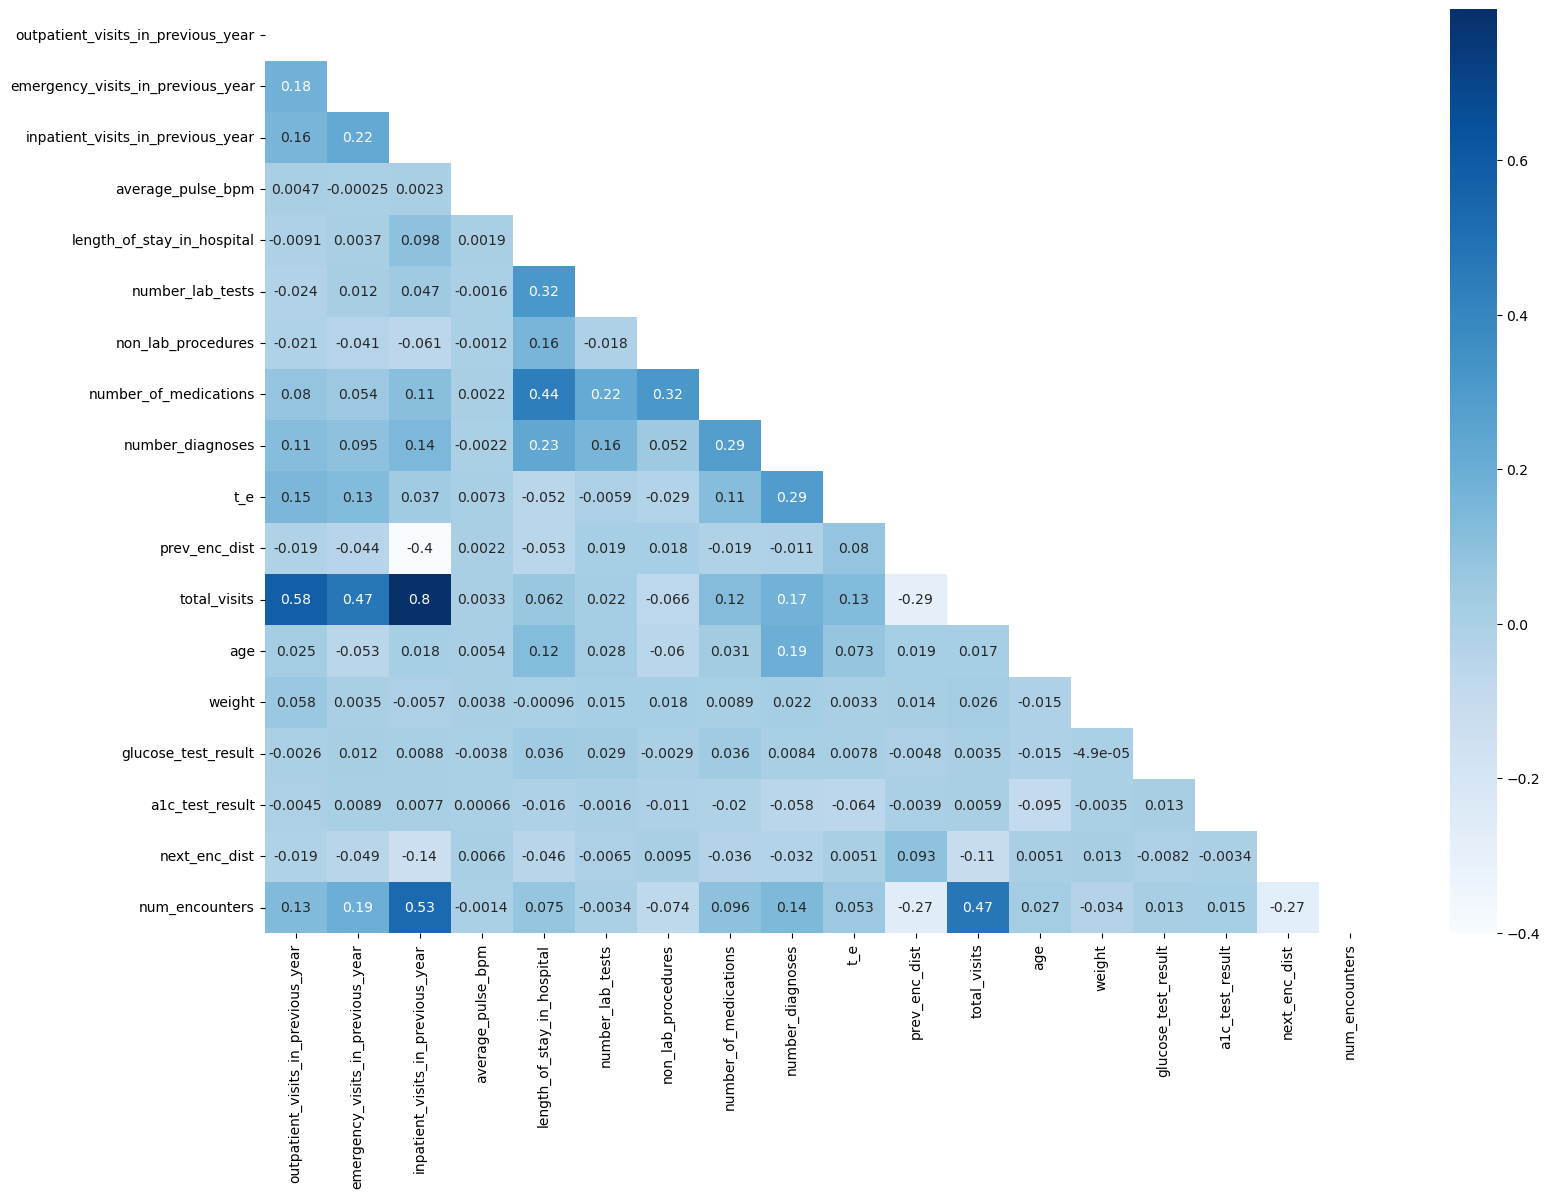

In [135]:
X_num = features_df[metric_features + semantically_metric_features + cheat_features]
scaler = MinMaxScaler()
scaler.fit(X_num)
features_num_scaled = scaler.transform(X_num) 

# Convert the array to a pandas dataframe
features_num_scaled = pd.DataFrame(features_num_scaled, columns = X_num.columns).set_index(features_df.index)


def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

cor = features_num_scaled.corr(method='spearman') 
matrix = np.triu(cor)

plt.figure(figsize=(18, 12))
sns.heatmap(cor, cmap="Blues", annot=True, mask=matrix)

# point biserial correlation

Point biserial correlation being a special case of Pearson correlation allows us to examine the relationship between a continuous variable and a binary target. 

In [136]:
def point_biserial(X, y, metric_features):
    '''
    Calculates pearson correlation that allows us to examine the relationship
    between a continuous variable and a binary target

    Args:
        X (pd.DataFrame): DataFrame containing all features.
        y (pd.Series): Binary target variable.
        metric_features: List of numeric columns
        
    Returns: 
        pd.DataFrame with feature names and whether to keep or discard them
    '''
    corrs = []
    p_values = []
    for col in metric_features:
        corr = pointbiserialr(X[col], y)
        corrs.append(corr[0])
        p_values.append(corr[1]) 
    
    binary = ['Discard' if p > 0.05 else 'Keep' for p in p_values]
    pb_c = pd.DataFrame(np.column_stack([corrs, p_values, binary]),
                         columns = ['correlation', 'p-value', 'Point Biserial'],
                         index = metric_features)
    return pb_c

### Mutual Information

This method sstimates mutual information for a discrete target variable.
Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [137]:
def calculate_mutual_information(X, y, numeric_columns, mi_threshold=0.01):
    '''
    Calculates mutual information for numeric features with a binary target.

    Args:
        X (pd.DataFrame): DataFrame containing all features.
        y (pd.Series): Binary target variable.
        numeric_columns: List of numeric columns
        mi_threshold: Threshold for mutual information to decide if a feature should be kept or discarded
        
    Returns: 
        DataFrame with feature names and whether to keep or discard them
    '''
    # Select only numeric features
    numeric_features = X[numeric_columns]

    # Calculate mutual information
    mi_scores = mutual_info_classif(numeric_features, y)

    # Create DataFrame with results
    mi_df = pd.DataFrame({
        'feature': numeric_features.columns,
        'MI scores': mi_scores,
        'Mutual Information': ['Keep' if mi > mi_threshold else 'Discard' for mi in mi_scores]
    })

    return mi_df.set_index('feature')

# Recursive Feature elimination with Cross-Validation (RFE CV)

Let's apply Recursive Feature Elimination (RFE CV) that will allow to select the most important features to keep. RFE uses a predictive model to run multiple times, always removing the "least important" variable before running again. The model used is what we call the *base estimator*. 

**IMPORTANT**
**RFE accepts as base estimator any predictive model that has a way of determining feature importance**. In the case for this example, the base estimator we will use is a Logistic Regression, which uses coefficients as the way to determine the importance of different variables.

In [138]:
def recursive_feature_elimination(X, y):
    '''
    Selects features with the highest importance scores
    
    Args:
        X_num (pd.DataFrame): DataFrame containing numeric features.
        y (pd.Series): Binary target variable.
        metric: metric features
        non_metric: non metric features
    
    Returns:
        pd.DataFrame with feature names and whether to keep or discard them
    '''

    min_features_to_select = 3
    cv = StratifiedKFold(10)
    
    #we'll take RandomForestClassifier as our base estimator
    clf = LogisticRegression(random_state=42, class_weight='balanced')

    # Create the pipeline with feature selection using RFE CV
    pipeline = Pipeline(steps=[
    ('feature_selection', RFECV(estimator=clf, 
                                step=1,
                                cv=cv, 
                                scoring='accuracy',
                                min_features_to_select=min_features_to_select))
    ])

    # Fit the pipeline on the data
    pipeline.fit(X, y)

    important_features = pd.Series(pipeline.named_steps['feature_selection'].support_, index=X.columns)
    rfe = important_features[important_features].index.tolist()

    rfe_df = pd.DataFrame({'feature' : X.columns})

    rfe_df['RFE CV'] = rfe_df['feature'].apply(lambda x: 'Keep' if x in rfe else 'Discard')
    return rfe_df.set_index('feature')


#### Embedded: Lasso Regression for numeric feature selection

In [139]:
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(6,5))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [140]:
def lasso_function(X, y):
    reg = LassoCV(cv=5, random_state=42).fit(X, y)
    
    coefs = pd.Series(reg.coef_, index = X.columns)

    # Determine whether to keep or discard each feature
    decisions = ['Keep' if coef != 0 else 'Discard' for coef in coefs]
    
    # Create a DataFrame with the results
    result_df = pd.DataFrame({'feature': X.columns, 'Coefficient': coefs, 'Lasso': decisions})
    result_df = result_df.set_index('feature')
    return result_df, coefs

_, coefs = lasso_function(features_num_scaled, target_binary)

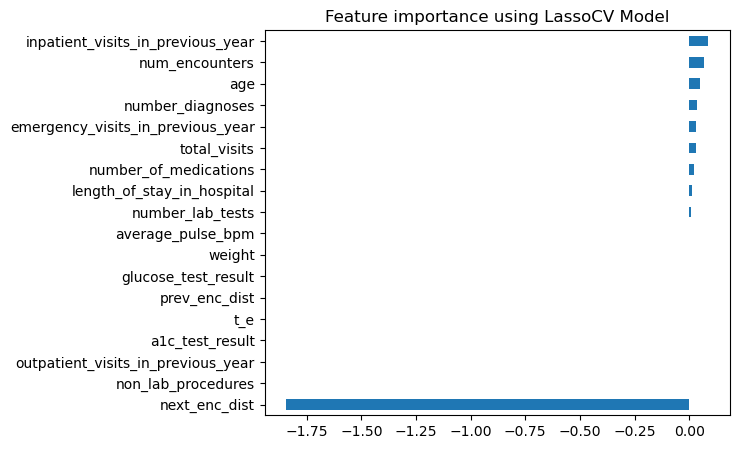

In [141]:
plot_importance(coefs, "LassoCV")

In [142]:
def feature_selection_aggregated(features, target_binary, metric_features, non_metric_features,
                                 features_num_scaled):
    chi = chi_2_selection(features, target_binary, non_metric_features)
    corr = spearman_selection(features_num_scaled, target_binary, threshold=0.1)
    pb_c = point_biserial(features, target_binary, metric_features)
    mi = calculate_mutual_information(features, target_binary, metric_features, mi_threshold=0.01)
    rfe = recursive_feature_elimination(features_num_scaled, target_binary)
    lasso_result, coefs = lasso_function(features_num_scaled, target_binary)
    merged = pd.concat([mi['Mutual Information'], chi['Chi-Squared'], corr['Spearman'], pb_c['Point Biserial'],
                     rfe['RFE CV'], lasso_result['Lasso']], axis=1).fillna('---')
    return merged

merged_df = feature_selection_aggregated(features_df, target_binary, metric_features_all, non_metric_features,
                                 features_num_scaled)

In [143]:
merged_df['Final Decision'] = merged_df.apply(lambda x: x.mode()[0], axis = 1)
merged_df.loc['insulin':,'Final Decision'] = merged_df.loc['insulin':,'Chi-Squared']
merged_df

,Mutual Information,Chi-Squared,Spearman,Point Biserial,RFE CV,Lasso,Final Decision
outpatient_visits_in_previous_year,Discard,---,Discard,Keep,Discard,Discard,Discard
emergency_visits_in_previous_year,Keep,---,Discard,Keep,Discard,Keep,Keep
inpatient_visits_in_previous_year,Keep,---,Keep,Keep,Keep,Keep,Keep
average_pulse_bpm,Discard,---,Discard,Discard,Discard,Keep,Discard
length_of_stay_in_hospital,Discard,---,Discard,Keep,Discard,Keep,Discard
number_lab_tests,Discard,---,Discard,Keep,Discard,Keep,Discard
non_lab_procedures,Discard,---,Discard,Keep,Discard,Keep,Discard
number_of_medications,Discard,---,Discard,Keep,Discard,Keep,Discard
number_diagnoses,Discard,---,Discard,Keep,Keep,Keep,Keep
t_e,Discard,---,Discard,Discard,Discard,Discard,Discard


In [144]:
features_new = merged_df[merged_df['Final Decision'] == 'Keep'].index
features_new

Index(['emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'number_diagnoses', 'total_visits',
       'next_enc_dist', 'num_encounters', 'age', 'insulin', 'glimepiride',
       'metformin', 'repaglinide', 'diabetes_diagnosis',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'has_payer_code', 'race', 'payer_code', 'admission_type',
       'medical_specialty', 'discharge_disposition', 'admission_source',
       'primary_diagnosis_grouped', 'secondary_diagnosis_grouped',
       'additional_diagnosis_grouped', 'medication', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis'],
      dtype='object')

# III. Binary Classification

In this part we will follow these steps:
- 1. We will take 2 models: 'simple' algorithm of **Logistic Regression** and more complicated one **HistGradientBoostingClassifier**
     and get baseline scores with soft (minimal preprocessing);
- 2. Train those models again, but now with hard preprocessing;
- 3. Apply various feature selection techniques to obtain a set of the most relevant features
- 4. Train models again and analize the findings
- 5. Perform hyperparameter tuning with the help of GridSearch with Cross-Validation
- 6. Obtain our best models with the best hyperparameters and conclude on findings.
- 7. Train Random Forest Classifier and Voting Classifier using a set of important features 
 
  



In [146]:
train_soft, _ = soft_preprosessing(train_mod)

In [147]:
X_soft = train_soft.drop(columns=["readmitted_binary", "readmitted_multiclass"])
y_soft = train_soft['readmitted_binary']

In [148]:
X_soft.columns

Index(['encounter_id', 'country', 'patient_id', 'race', 'gender', 'age',
       'weight', 'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'encounters', 't_e', 'p_e', 'num_encounters',
       'next_enc_dist', 'prev_enc_dist', 'insulin', 'glimepiride', 'metformin',
       'glipizide', 'nateglinide', 'glyburide', 'rosiglitazone', 'repaglinide',
       'pioglitazone', 'acarbose'],
      dtype='object')

In [149]:
X_soft.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharge_disposition,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,encounters,t_e,p_e,num_encounters,next_enc_dist,prev_enc_dist,insulin,glimepiride,metformin,glipizide,nateglinide,glyburide,rosiglitazone,repaglinide,pioglitazone,acarbose
0,533253,USA,70110,Caucasian,False,7.0,<NA>,NaN,0,0,2,Emergency,Family/GeneralPractice,127,Discharged to home,Emergency Room,2,48,0,20,515,276,466,8,NaN,NaN,0,0,,"[533253, 798191, 269442, 811652, 819387, 819977]",8965,2,6,2794.0,1667.0,0,0,0,0,0,0,0,0,0,0
2,634063,USA,80729253,Caucasian,False,6.0,<NA>,NaN,0,0,1,NaN,Family/GeneralPractice,94,Discharged to home,NaN,6,60,1,22,534,135,250,6,NaN,NaN,1,1,"glimepiride,insulin",[634063],109775,2,1,NaN,NaN,1,1,0,0,0,0,0,0,0,0
3,890610,USA,2919042,AfricanAmerican,True,6.0,<NA>,MC,0,0,1,Emergency,InternalMedicine,81,Discharged to home,Transfer from another health care facility,6,48,2,9,569,562,455,5,NaN,NaN,0,0,,[890610],104178,3,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0
4,654194,USA,84871971,Caucasian,False,7.0,<NA>,HM,1,0,0,Elective,NaN,126,Discharged/transferred to home with home healt...,Physician Referral,6,47,1,15,715,599,428,9,NaN,NaN,0,0,,"[654194, 957510]",129906,2,2,41172.0,NaN,0,0,0,0,0,0,0,0,0,0
5,269878,USA,279288,Caucasian,False,5.0,<NA>,NaN,0,0,0,Emergency,Surgery-General,93,Discharged to home,Emergency Room,3,58,2,10,574,250,244,3,NaN,0,0,0,,[269878],7734,1,1,NaN,NaN,0,0,0,0,0,0,0,0,0,0


**train features with soft preprocessing**

In [297]:
metric_features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses',
    't_e',
    'prev_enc_dist'
]

cheat_features = [
    'next_enc_dist',
    'num_encounters'
]

semantically_metric_features = [
    "age",
    'weight',
    'glucose_test_result',
    'a1c_test_result'
]

    
med_binary_features = []
    
binary_features = [
    'gender',
    'change_in_meds_during_hospitalization',
    'prescribed_diabetes_meds'
]

high_cardinal_categorical_features = [
    'medication',
    'primary_diagnosis',
    'secondary_diagnosis',
    'additional_diagnosis'
]

low_cardinal_categorical_features = [
    'race',
    'payer_code',
    'admission_type',
    'medical_specialty',
    'discharge_disposition',
    'admission_source',
    'p_e',
]

categorical_features = low_cardinal_categorical_features + high_cardinal_categorical_features

len(metric_features) + len(cheat_features) + len(semantically_metric_features) + len(med_binary_features) + len(binary_features) + len(low_cardinal_categorical_features) + len(high_cardinal_categorical_features)

31

## Step 1: Soft (Minimal) Preprocessing

### **Minimal Preprocessing** Logistic Regression

In [169]:
def preprocessor_lr(use_engineered_features=False, all=None, do_cheat=False, max_cat=253, min_freq=0.003):
    '''
    Creates preprocessor for logistic regression
    '''

    log_metric_transformer = Pipeline(
        steps=[('inputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
               ('log_transform', FunctionTransformer(np.log1p)),
               ('scaler', MinMaxScaler(feature_range = (-1, 1)))
               ])
    
    metric_transformer = Pipeline(
        steps=[('inputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
               ('scaler', MinMaxScaler())
               ])

    one_hot_transformer = Pipeline(steps=[('encoder', OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        min_frequency=min_freq,
        max_categories=max_cat,
        sparse_output=False))])
    
    target_transformer = Pipeline(steps=[('encoder', TargetEncoder())])
    
    if all == None:
        one_hot_features = low_cardinal_categorical_features
        target_features = high_cardinal_categorical_features
    elif all == 'target':
        one_hot_features = []
        target_features = categorical_features
    elif all == 'one_hot':
        one_hot_features = categorical_features
        target_features = []
    else:
        raise Exception("Unknown value of all parameter")

    preprocessor = ColumnTransformer(
            transformers=[
                ("log", log_metric_transformer, 
                 metric_features
                 + semantically_metric_features
                 + (cheat_features if do_cheat else [])), 
                ("metric", metric_transformer, binary_features 
                 + (med_binary_features if use_engineered_features else [])),
                ("one_hot", one_hot_transformer, one_hot_features),
                ("target", target_transformer, target_features)],
            sparse_threshold=0,
            verbose_feature_names_out=False
    )
    preprocessor.set_output(transform="pandas")
    return preprocessor

In [170]:
def run(X, y, preprocessor, cls):

    if len(y.unique()) <= 2:
        custom_scorer = {
            'f1': make_scorer(f1_score),
            'balanced accuracy': make_scorer(balanced_accuracy_score),
            'roc auc': make_scorer(roc_auc_score, needs_proba=True),
        }
    else:
        custom_scorer = {
            'f1': make_scorer(f1_score, average='weighted'),
            'balanced accuracy': make_scorer(balanced_accuracy_score),
            'roc auc': make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True),
       }
        
    
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', cls)
                           ])

    cross_val_results = cross_validate(model,
                                       X,
                                       y,
                                       cv=stratified_kfold,
                                       scoring=custom_scorer,
                                       return_estimator=True,
                                       return_train_score=True)

    bi = cross_val_results['test_f1'].argmax()
    
    best_model = cross_val_results['estimator'][bi]
    
    results = {}
    for c in custom_scorer.keys():
        results[(c, 'test max')] = {0: cross_val_results[f'test_{c}'][bi]}            
        results[(c, 'test avg')] = {0: np.average(cross_val_results[f'test_{c}'])}
        results[(c, 'train avg')] = {0: np.average(cross_val_results[f'train_{c}'])}
        
    results = pd.DataFrame(results) 
    
    return best_model, results

In [171]:
best_model_lr, results = run(X_soft, y_soft,
    preprocessor_lr(use_engineered_features=False),
    LogisticRegression(random_state = 42, class_weight={0: 0.14, 1: 1}))

In [172]:
results_lr = pd.DataFrame()
def fill_results(df, prep, setup, results):
    results['Preprocessing'] = prep
    results['Setup'] = setup
    results.set_index(['Preprocessing', 'Setup'], inplace=True)
    return df.append(results)

In [173]:
results_lr = fill_results(results_lr, 'Minimal', 'low_card: one hot; high_card: target', results)

In [174]:
best_model, results = run(X_soft, y_soft,
    preprocessor_lr(use_engineered_features=False, all="target"),
    LogisticRegression(random_state = 42, class_weight={0: 0.14, 1: 1}))

In [175]:
results_lr = fill_results(results_lr, 'Minimal', 'low_card: target; high_card: target', results)

In [176]:
best_model, results = run(X_soft, y_soft,
    preprocessor_lr(use_engineered_features=False, all="one_hot"),
    LogisticRegression(random_state = 42, class_weight={0: 0.14, 1: 1}))

In [177]:
results_lr = fill_results(results_lr, 'Minimal', 'low_card: one hot; high_card: one hot', results)

In [178]:
pd.set_option('display.max_colwidth', -1)

In [179]:
results_lr

f1            \
                                                     test max  test avg   
Preprocessing Setup                                                       
Minimal       low_card: one hot; high_card: target   0.289302  0.281978   
              low_card: target; high_card: target    0.290129  0.282852   
              low_card: one hot; high_card: one hot  0.287047  0.280554   

                                                               \
                                                    train avg   
Preprocessing Setup                                             
Minimal       low_card: one hot; high_card: target   0.299949   
              low_card: target; high_card: target    0.299385   
              low_card: one hot; high_card: one hot  0.292383   

                                                    balanced accuracy  \
                                                             test max   
Preprocessing Setup                                                     
Minimal       low_card: one hot; high_card: target   0.631432           
              low_card: target; high_card: target    0.630399           
              low_card: one hot; high_card: one hot  0.630821           

                                                                         \
                                                     test avg train avg   
Preprocessing Setup                                                       
Minimal       low_card: one hot; high_card: target   0.624001  0.642720   
              low_card: target; high_card: target    0.622794  0.639535   
              low_card: one hot; high_card: one hot  0.623472  0.635897   

                                                      roc auc            \
                                                     test max  test avg   
Preprocessing Setup                                                       
Minimal       low_card: one hot; high_card: target   0.684620  0.680725   
              low_card: target; high_card: target    0.682261  0.679066   
              low_card: one hot; high_card: one hot  0.676557  0.675558   

                                                               
                                                    train avg  
Preprocessing Setup                                            
Minimal       low_card: one hot; high_card: target   0.707005  
              low_card: target; high_card: target    0.703531  
              low_card: one hot; high_card: one hot  0.696103

### **Minimal Preprocessing** HistGradientBoosting Classifier

In [180]:
def preprocessor_tree(use_engineered_features=False, all=None, do_cheat=False, max_cat=253, keepna=True):
    
    ordinal_transformer = Pipeline(
        ([] if keepna else [('inputer', SimpleImputer(
            missing_values=np.nan, strategy='constant', fill_value='NaN2Missing'))]) + 
        [('encoder', OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=np.nan if keepna else max_cat,
            max_categories=max_cat))])

    target_transformer = Pipeline([('encoder', TargetEncoder())])
    
    if all == None:
        ordinal_features = low_cardinal_categorical_features
        target_features = high_cardinal_categorical_features
    elif all == 'target':
        ordinal_features = []
        target_features = categorical_features
    elif all == 'ordinal':
        ordinal_features = categorical_features
        target_features = []
    else:
        raise Exception("Unknown value of all parameter")
    
    preprocessor = Pipeline([
        ('transforms', ColumnTransformer(
            transformers=[
                ("metric", "passthrough" if keepna else SimpleImputer(missing_values=np.nan, strategy='mean'), 
                 metric_features
                 + semantically_metric_features
                 + binary_features
                 + (med_binary_features if use_engineered_features else [])
                 + (cheat_features if do_cheat else [])
                ),
                ("ordinal", ordinal_transformer, ordinal_features),
                ("target", target_transformer, target_features)],
            sparse_threshold=0,
            verbose_feature_names_out=False
        ))])
    
    preprocessor.set_output(transform="pandas")
    return preprocessor

In [181]:
results_hist = pd.DataFrame()

best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False),
    HistGradientBoostingClassifier(categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Minimal', 'low_card: ordinal->categorical; high_card: target', results)


best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False, all = 'target'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Minimal', 'low_card: target->categorical; high_card: target', results)

best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False, all = 'target'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=None,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Minimal', 'low_card: target; high_card: target', results)


best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False, all = 'ordinal'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Minimal', 'low_card: ordinal->categorical; high_card: ordinal', results)

best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False, all = 'ordinal', max_cat=20),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Minimal', 'low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical', results)

best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False, all = 'ordinal', max_cat=15),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))


results_hist = fill_results(results_hist, 'Minimal', 'low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical', results)



In [182]:
results_hist

f1  \
                                                                                           test max   
Preprocessing Setup                                                                                   
Minimal       low_card: ordinal->categorical; high_card: target                            0.305181   
              low_card: target->categorical; high_card: target                             0.124932   
              low_card: target; high_card: target                                          0.299145   
              low_card: ordinal->categorical; high_card: ordinal                           0.305147   
              low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical  0.302161   
              low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical  0.301165   

                                                                                                     \
                                                                                           test avg   
Preprocessing Setup                                                                                   
Minimal       low_card: ordinal->categorical; high_card: target                            0.296107   
              low_card: target->categorical; high_card: target                             0.036686   
              low_card: target; high_card: target                                          0.292450   
              low_card: ordinal->categorical; high_card: ordinal                           0.295448   
              low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical  0.293482   
              low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical  0.293261   

                                                                                                     \
                                                                                          train avg   
Preprocessing Setup                                                                                   
Minimal       low_card: ordinal->categorical; high_card: target                            0.336668   
              low_card: target->categorical; high_card: target                             0.037716   
              low_card: target; high_card: target                                          0.329083   
              low_card: ordinal->categorical; high_card: ordinal                           0.331227   
              low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical  0.343517   
              low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical  0.336784   

                                                                                          balanced accuracy  \
                                                                                                   test max   
Preprocessing Setup                                                                                           
Minimal       low_card: ordinal->categorical; high_card: target                            0.647782           
              low_card: target->categorical; high_card: target                             0.529889           
              low_card: target; high_card: target                                          0.641106           
              low_card: ordinal->categorical; high_card: ordinal                           0.644646           
              low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical  0.640620           
              low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical  0.641414           

                                                                                                     \
                                                                                           test avg   
Preprocessing Setup                                                                                   
Mini

### Class weight: balanced or {0: 0.14, 1: 1})

Models' performance can benefit from changing class_weight hyperparameter from "balanced" to {0: 0.14, 1: 1} giving a bit for focus to class 0 (Not Readmitted)

In [185]:
results_balance = pd.DataFrame()

best_model, results = run(X_soft, y_soft,
    preprocessor_lr(use_engineered_features=False, all="one_hot"),
    LogisticRegression(random_state = 42, class_weight={0: 0.14, 1: 1}))

results_balance = fill_results(results_balance, 'Minimal', 'Logistic Reg: {0:0.14, 1: 1}', results)

best_model, results = run(X_soft, y_soft,
    preprocessor_lr(use_engineered_features=False, all="one_hot"),
    LogisticRegression(random_state = 42, class_weight='balanced'))

results_balance = fill_results(results_balance, 'Minimal', 'Logistic Reg: balanced', results)

In [186]:
best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False, all = 'ordinal'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))
results_balance = fill_results(results_balance, 'Minimal', 'HistBoost: {0:0.14, 1: 1}', results)

best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight='balanced',
                                   max_iter=512,
                                   learning_rate=0.007))

results_balance = fill_results(results_balance, 'Minimal', 'HistBoost: balanced', results)
results_balance

f1                      \
                                            test max  test avg train avg   
Preprocessing Setup                                                        
Minimal       Logistic Reg: {0:0.14, 1: 1}  0.287047  0.280554  0.292383   
              Logistic Reg: balanced        0.279695  0.274867  0.287091   
              HistBoost: {0:0.14, 1: 1}     0.305147  0.295448  0.331227   
              HistBoost: balanced           0.295843  0.290402  0.325613   

                                           balanced accuracy            \
                                                    test max  test avg   
Preprocessing Setup                                                      
Minimal       Logistic Reg: {0:0.14, 1: 1}  0.630821          0.623472   
              Logistic Reg: balanced        0.630742          0.624462   
              HistBoost: {0:0.14, 1: 1}     0.644646          0.635062   
              HistBoost: balanced           0.647824          0.641407   

                                                       roc auc            \
                                           train avg  test max  test avg   
Preprocessing Setup                                                        
Minimal       Logistic Reg: {0:0.14, 1: 1}  0.635897  0.676557  0.675558   
              Logistic Reg: balanced        0.638980  0.679984  0.675085   
              HistBoost: {0:0.14, 1: 1}     0.670932  0.695228  0.691179   
              HistBoost: balanced           0.682852  0.699214  0.694755   

                                                      
                                           train avg  
Preprocessing Setup                                   
Minimal       Logistic Reg: {0:0.14, 1: 1}  0.696103  
              Logistic Reg: balanced        0.696169  
              HistBoost: {0:0.14, 1: 1}     0.746595  
              HistBoost: balanced           0.752957

## **Step 2**: Hard Preprocessing and Feature Engineering

### **Hard Preprocessing and Feature Engineering** Logistic Regression

In [187]:
train_hard, _ = hard_preprocessing(train_mod)
X_hard = train_hard.drop(columns=["readmitted_binary", "readmitted_multiclass"])
y_hard = train_hard['readmitted_binary']

In [298]:
metric_features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses',
    't_e',
    'prev_enc_dist',
    'total_visits'
]


cheat_features = [
    'next_enc_dist',
    'num_encounters'
]

semantically_metric_features = [
    "age",
    'weight',
    'glucose_test_result',
    'a1c_test_result'
]

med_binary_features = [
    'insulin',
    'glimepiride',
    'metformin',
    'glipizide',
    'nateglinide',
    'glyburide',
    'rosiglitazone',
    'repaglinide',
    'pioglitazone',
    'acarbose',
    'diabetes_diagnosis',
    'onco_diagnosis',
    'psycho_diagnosis'
]

    
binary_features = [
    'gender',
    'change_in_meds_during_hospitalization',
    'prescribed_diabetes_meds',
    'has_payer_code'
]

high_cardinal_categorical_features = [
    'medication',
    'primary_diagnosis',
    'secondary_diagnosis',
    'additional_diagnosis'
]

low_cardinal_categorical_features = [
    'race',
    'payer_code',
    'admission_type',
    'medical_specialty',
    'discharge_disposition',
    'admission_source',
    'p_e',
    'primary_diagnosis_grouped',
    'secondary_diagnosis_grouped',
    'additional_diagnosis_grouped',
]

categorical_features = low_cardinal_categorical_features + high_cardinal_categorical_features

len(metric_features) + len(cheat_features) + len(semantically_metric_features) + len(med_binary_features) + len(binary_features) + len(low_cardinal_categorical_features) + len(high_cardinal_categorical_features)

49

In [191]:
best_model, results = run(X_hard, y_hard,
    preprocessor_lr(use_engineered_features=True),
    LogisticRegression(random_state = 42, class_weight={0: 0.14, 1: 1}))

results_lr = fill_results(results_lr, 'Hard Preprocessing + Feature Engineering', 'low_card: one hot; high_card: target', results)

In [192]:
best_model, results = run(X_hard, y_hard,
    preprocessor_lr(use_engineered_features=True, all="target"),
    LogisticRegression(random_state = 42, class_weight={0: 0.14, 1: 1}))

results_lr  = fill_results(results_lr, 'Hard Preprocessing + Feature Engineering', 'low_card: target; high_card: target', results)

In [193]:
best_model, results = run(X_hard, y_hard,
    preprocessor_lr(use_engineered_features=True, all="one_hot"),
    LogisticRegression(random_state = 42, class_weight={0: 0.14, 1: 1}))

results_lr = fill_results(results_lr, 'Hard Preprocessing + Feature Engineering', 'low_card: one hot; high_card: one hot', results)

In [194]:
results_lr

f1  \
                                                                                test max   
Preprocessing                            Setup                                             
Minimal                                  low_card: one hot; high_card: target   0.289302   
                                         low_card: target; high_card: target    0.290129   
                                         low_card: one hot; high_card: one hot  0.287047   
Hard Preprocessing + Feature Engineering low_card: one hot; high_card: target   0.287639   
                                         low_card: target; high_card: target    0.288171   
                                         low_card: one hot; high_card: one hot  0.285523   

                                                                                          \
                                                                                test avg   
Preprocessing                            Setup                                             
Minimal                                  low_card: one hot; high_card: target   0.281978   
                                         low_card: target; high_card: target    0.282852   
                                         low_card: one hot; high_card: one hot  0.280554   
Hard Preprocessing + Feature Engineering low_card: one hot; high_card: target   0.274670   
                                         low_card: target; high_card: target    0.272275   
                                         low_card: one hot; high_card: one hot  0.274476   

                                                                                          \
                                                                               train avg   
Preprocessing                            Setup                                             
Minimal                                  low_card: one hot; high_card: target   0.299949   
                                         low_card: target; high_card: target    0.299385   
                                         low_card: one hot; high_card: one hot  0.292383   
Hard Preprocessing + Feature Engineering low_card: one hot; high_card: target   0.288090   
                                         low_card: target; high_card: target    0.283392   
                                         low_card: one hot; high_card: one hot  0.285758   

                                                                               balanced accuracy  \
                                                                                        test max   
Preprocessing                            Setup                                                     
Minimal                                  low_card: one hot; high_card: target   0.631432           
                                         low_card: target; high_card: target    0.630399           
                                         low_card: one hot; high_card: one hot  0.630821           
Hard Preprocessing + Feature Engineering low_card: one hot; high_card: target   0.630494           
                                         low_card: target; high_card: target    0.629695           
                                         low_card: one hot; high_card: one hot  0.628432           

                                                                                          \
                                                                                test avg   
Preprocessing                            Setup                                             
Minimal                                  low_card: one hot; high_card: target   0.624001   
                                         low_card: target; high_card: target    0.622794   
                                         low_card: one hot; high_card: one hot  0.623472   
Hard Preprocessing + Feature Engineering low_card: one hot; high_card: target   0.616113   
                                         low_card: tar

### **Hard Preprocessing and Feature Engineering** HistGradientBoosting Classifier

In [195]:
best_model, results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Hard Preprocessing + Feature Engineering', 'low_card: ordinal->categorical; high_card: target', results)

best_model,  results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True, all = 'target'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Hard Preprocessing + Feature Engineering', 'low_card: target->categorical; high_card: target', results)

best_model, results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True, all = 'target'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=None,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Hard Preprocessing + Feature Engineering', 'low_card: target; high_card: target', results)

best_model, results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True, all = 'ordinal'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Hard Preprocessing + Feature Engineering', 'low_card: ordinal->categorical; high_card: ordinal', results)

best_model, results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True, all = 'ordinal', max_cat=20),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Hard Preprocessing + Feature Engineering', 'low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical', results)

best_model, results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True, all = 'ordinal', max_cat=15),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Hard Preprocessing + Feature Engineering', 'low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical', results)

best_model, results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True, all = 'ordinal'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

results_hist = fill_results(results_hist, 'Hard Preprocessing + Feature Engineering', 'low_card: ordinal->categorical; high_card: ordinal->categorical', results)

In [302]:
results_hist

f1  \
                                                                                                                      test max   
Preprocessing                            Setup                                                                                   
Minimal                                  low_card: ordinal->categorical; high_card: target                            0.305181   
                                         low_card: target->categorical; high_card: target                             0.124932   
                                         low_card: target; high_card: target                                          0.299145   
                                         low_card: ordinal->categorical; high_card: ordinal                           0.305147   
                                         low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical  0.302161   
                                         low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical  0.301165   
Hard Preprocessing + Feature Engineering low_card: ordinal->categorical; high_card: target                            0.304711   
                                         low_card: target->categorical; high_card: target                             0.203613   
                                         low_card: target; high_card: target                                          0.301563   
                                         low_card: ordinal->categorical; high_card: ordinal                           0.304612   
                                         low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical  0.298271   
                                         low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical  0.304450   
                                         low_card: ordinal->categorical; high_card: ordinal->categorical              0.291792   

                                                                                                                                \
                                                                                                                      test avg   
Preprocessing                            Setup                                                                                   
Minimal                                  low_card: ordinal->categorical; high_card: target                            0.296107   
                                         low_card: target->categorical; high_card: target                             0.036686   
                                         low_card: target; high_card: target                                          0.292450   
                                         low_card: ordinal->categorical; high_card: ordinal                           0.295448   
                                         low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical  0.293482   
                                         low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical  0.293261   
Hard Preprocessing + Feature Engineering low_card: ordinal->categorical; high_card: target                            0.289513   
                                         low_card: target->categorical; high_card: target                             0.203581   
                                         low_card: target; high_card: target                                          0.285622   
                                         low_card: ordinal->categorical; high_card: ordinal                           0.289406   
                                         low_card: ordinal_max20->categorical; high_card: ordinal_max20->categorical  0.289414   
                                         low_card: ordinal_max15->categorical; high_card: ordinal_max15->categorical  0.288903   
                                         low_card: ordinal->categorical; high_card: ordinal->

**Findings**

## **Step 4:** Train both models again on the selected features

In [197]:
metric_features = [
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'total_visits'
]

cheat_features = [
    'next_enc_dist',
    'num_encounters'
]

semantically_metric_features = [
    "age"
]

    
med_binary_features = [
    'insulin',
    'glimepiride',
    'metformin',
    'repaglinide',
    'diabetes_diagnosis'
]

    
binary_features = [
    'change_in_meds_during_hospitalization',
    'prescribed_diabetes_meds',
    'has_payer_code'
]

high_cardinal_categorical_features = [
    'primary_diagnosis',
    'secondary_diagnosis',
    'additional_diagnosis',
    'medication'
]

low_cardinal_categorical_features = [
    'race',
    'payer_code',
    'admission_type',
    'medical_specialty',
    'discharge_disposition',
    'admission_source',
    'p_e',
    'primary_diagnosis_grouped',
    'secondary_diagnosis_grouped',
    'additional_diagnosis_grouped',
]

categorical_features = low_cardinal_categorical_features + high_cardinal_categorical_features

len(metric_features) + len(cheat_features) + len(semantically_metric_features) + len(med_binary_features) + len(binary_features) + len(low_cardinal_categorical_features) + len(high_cardinal_categorical_features)

28

In [217]:
selected_results = pd.DataFrame()

best_model, results = run(X_hard, y_hard,
    preprocessor_lr(use_engineered_features=True),
    LogisticRegression(random_state=42, class_weight={0: 0.14, 1: 1}))

selected_results = fill_results(selected_results, '[Logistic Regresion] Hard Preprocessing + Feature Engineering + Feature Elimination', 'low_card: ordinal->categorical; high_card: ordinal', results)

In [218]:
best_model, results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

selected_results = fill_results(selected_results, '[HistBoost] Hard Preprocessing + Feature Engineering + Feature Elimination', 'low_card: ordinal->categorical; high_card: target', results)


best_model, results = run(X_hard, y_hard,
    preprocessor_tree(use_engineered_features=True, all='ordinal'),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.14, 1: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

selected_results = fill_results(selected_results, '[HistBoost] Hard Preprocessing + Feature Engineering + Feature Elimination', 'low_card: ordinal->categorical; high_card: ordinal', results)



In [204]:
selected_results

f1  \
                                                                                                                                        test max   
Preprocessing                                                                       Setup                                                          
[Logistic Regresion] Hard Preprocessing + Feature Engineering + Feature Elimination low_card: ordinal->categorical; high_card: ordinal  0.287205   
[HistBoost] Hard Preprocessing + Feature Engineering + Feature Elimination          low_card: ordinal->categorical; high_card: target   0.296076   
                                                                                    low_card: ordinal->categorical; high_card: ordinal  0.291185   

                                                                                                                                                  \
                                                                                                                                        test avg   
Preprocessing                                                                       Setup                                                          
[Logistic Regresion] Hard Preprocessing + Feature Engineering + Feature Elimination low_card: ordinal->categorical; high_card: ordinal  0.273182   
[HistBoost] Hard Preprocessing + Feature Engineering + Feature Elimination          low_card: ordinal->categorical; high_card: target   0.279937   
                                                                                    low_card: ordinal->categorical; high_card: ordinal  0.278632   

                                                                                                                                                  \
                                                                                                                                       train avg   
Preprocessing                                                                       Setup                                                          
[Logistic Regresion] Hard Preprocessing + Feature Engineering + Feature Elimination low_card: ordinal->categorical; high_card: ordinal  0.286990   
[HistBoost] Hard Preprocessing + Feature Engineering + Feature Elimination          low_card: ordinal->categorical; high_card: target   0.324759   
                                                                                    low_card: ordinal->categorical; high_card: ordinal  0.318382   

                                                                                                                                       balanced accuracy  \
                                                                                                                                                test max   
Preprocessing                                                                       Setup                                                                  
[Logistic Regresion] Hard Preprocessing + Feature Engineering + Feature Elimination low_card: ordinal->categorical; high_card: ordinal  0.630043           
[HistBoost] Hard Preprocessing + Feature Engineering + Feature Elimination          low_card: ordinal->categorical; high_card: target   0.636772           
                                                                                    low_card: ordinal->categorical; high_card: ordinal  0.632694           

                                                                                                                                                  \
                                                                                                                                        test avg   
Preprocessing                                                                       Setup                                                          
[Logistic Regresion] Hard Preprocessing + Feature Engineering + Feature Elimination low_card: 

## **Step 5:** Perform hyperparameter tuning with GridSearchCV

In [213]:
metric_features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses',
    't_e',
    'prev_enc_dist'
]

cheat_features = [
    'next_enc_dist',
    'num_encounters'
]

semantically_metric_features = [
    "age",
    'weight',
    'glucose_test_result',
    'a1c_test_result'
]

    
med_binary_features = []

    
binary_features = [
    'gender',
    'change_in_meds_during_hospitalization',
    'prescribed_diabetes_meds'
]

high_cardinal_categorical_features = [
    'medication',
    'primary_diagnosis',
    'secondary_diagnosis',
    'additional_diagnosis'
]

low_cardinal_categorical_features = [
    'race',
    'payer_code',
    'admission_type',
    'medical_specialty',
    'discharge_disposition',
    'admission_source',
    'p_e',
]

categorical_features = low_cardinal_categorical_features + high_cardinal_categorical_features

len(metric_features) + len(cheat_features) + len(semantically_metric_features) + len(med_binary_features) + len(binary_features) + len(low_cardinal_categorical_features) + len(high_cardinal_categorical_features)

31

In [214]:
def run_grid(X, y, preprocessor, cls, grid_params):
    custom_scorer = {
        'balanced_accuracy': make_scorer(balanced_accuracy_score),
        'f1_score': make_scorer(f1_score),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    }
    
    preprocessor = preprocessor if preprocessor else 'passthrough'
    model = Pipeline([('preprocessor', preprocessor), ('classifier', cls)])

    scv = GridSearchCV(model, 
                       {'classifier__' + k: v for k, v in grid_params.items()},
                       scoring=custom_scorer,
                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                       refit=False)
    
    scv.fit(X, y)
    
    return pd.DataFrame({k.replace('param_classifier_', 'p_'): v for k, v in scv.cv_results_.items()})

In [219]:
scv = run_grid(X_soft, y_soft,
               preprocessor_tree(use_engineered_features=False, all='target', keepna=False),
               RandomForestClassifier(class_weight={0: 0.14, 1: 1},
                                      n_estimators=200,
                                      random_state = 42),
              {'max_depth': [9, 10, 11, 12],
               'ccp_alpha': [0.0001, 0.00015, 0.0002, 0.00025]})

In [231]:
pd.concat([scv.filter(regex=r'p__.*|mean.*'),
           scv.filter(regex=r'^split\d_test_f1_score$').max(axis=1).rename('max_test_f1')],
          axis=1).sort_values(by=['p__max_depth', 'p__ccp_alpha'])

,mean_fit_time,mean_score_time,p__ccp_alpha,p__max_depth,mean_test_balanced_accuracy,mean_test_f1_score,mean_test_roc_auc,max_test_f1
0,11.940917,0.603164,0.0001,9,0.624121,0.292988,0.688347,0.297908
4,10.972632,0.551493,0.00015,9,0.624859,0.291392,0.688860,0.301993
8,11.063648,0.517130,0.0002,9,0.630299,0.295114,0.689710,0.301257
12,10.888598,0.508262,0.00025,9,0.630738,0.292881,0.689083,0.299048
1,12.705297,0.598336,0.0001,10,0.621272,0.293768,0.688871,0.298029
5,12.964232,0.611698,0.00015,10,0.623868,0.293382,0.690455,0.301594
9,13.198853,0.608425,0.0002,10,0.628707,0.295343,0.690887,0.301721
13,12.158508,0.538402,0.00025,10,0.629198,0.292168,0.689911,0.301108
2,13.264609,0.609103,0.0001,11,0.615099,0.291707,0.689129,0.296152
6,14.644383,0.614959,0.00015,11,0.622548,0.295517,0.689949,0.303753


## **Step 6**: Voting Classifier with best setup (Minimal)

#### Voting Classifier with 3 models: HistGradientBoostingClassifier (Ordinal and Target encoding), HistGradientBoostingClassifier (Ordinal Encoding) and Random Forest Classifier (Target Encoding)


In [234]:
best_model, results = run(X_soft, y_soft, 
    None,
    VotingClassifier([
        ('HGB-OT', Pipeline([
            ('p', preprocessor_tree(use_engineered_features=False)),
            ('c', HistGradientBoostingClassifier(random_state=42,
                categorical_features=low_cardinal_categorical_features,
                class_weight={0: 0.14, 1: 1},
                max_iter=512,
                learning_rate=0.007))]
            )),
        ('HGB-OO', Pipeline([
            ('p', preprocessor_tree(use_engineered_features=False, all='ordinal')),
            ('c', HistGradientBoostingClassifier(random_state=42,
                categorical_features=low_cardinal_categorical_features,
                class_weight={0: 0.14, 1: 1},
                max_iter=512,
                learning_rate=0.007))]
            )),
        ('RF', Pipeline([
            ('p', preprocessor_tree(use_engineered_features=False, all='target', keepna=False)),
            ('c', RandomForestClassifier(random_state=42,
                class_weight={0: 0.14, 1: 1},
                max_depth=11,
                ccp_alpha=0.0002,
                n_estimators=200))]
            )),
        #('LR', Pipeline([
        #    ('p', preprocessor_lr(use_engineered_features=True)),
        #    ('c', LogisticRegression(class_weight={0: 0.14, 1: 1}, penalty='l1', solver='saga'))]
        #))
        ],
        voting='soft'))

In [235]:
results

f1                     balanced accuracy                      \
   test max  test avg train avg          test max  test avg train avg   
0  0.305213  0.296984  0.34474   0.642368          0.633883  0.680025   

    roc auc                      
   test max  test avg train avg  
0  0.699135  0.696539  0.758275

## Scores with Cheat Features

In [262]:
best_model, results = run(X_soft, y_soft,
    preprocessor_tree(use_engineered_features=False, do_cheat=True),
    HistGradientBoostingClassifier(random_state=42,
        categorical_features=low_cardinal_categorical_features,
        class_weight={0: 0.33, 1: 1},
        max_iter=512,
        learning_rate=0.007))

In [263]:
results

f1                     balanced accuracy                      roc auc  \
  test max  test avg train avg          test max test avg train avg  test max   
0  0.60793  0.602165  0.630169  0.739155          0.73446  0.748031  0.852562   

                       
   test avg train avg  
0  0.846206  0.881775

### Kaggle Submition

In [280]:
test = test_data.copy()

In [282]:
all_t = all_mod.set_index(['encounter_id'])
test.set_index(['encounter_id'], inplace=True)

test = all_t.loc[test.index,]

test.reset_index(inplace=True)
test.set_index('encounter_id', inplace=True)

In [287]:
test_soft, _ = soft_preprosessing(test)

In [288]:
# Make predictions on the preprocessed test data
y_test_pred = best_model.predict(test_soft)

In [289]:
sub = pd.DataFrame(y_test_pred, index = test_soft.index)
sub.columns = ["readmitted_binary"]
sub["readmitted_binary"] = sub["readmitted_binary"].map({1: "Yes", 0: "No"})
sub.to_csv('Group33__Version52.csv')
sub["readmitted_binary"].value_counts()

No     27740
Yes    2790 
Name: readmitted_binary, dtype: int64

# IV. Multiclass Classification

In this part we will follow these steps:
- 1. Divide train dataset into 2 ones: train (on which we'll perform crossvalidation) and test
- 2. We will train take best models obtained on Binary Classification  **HistGradientBoostingClassifier, RandomForestClassifier and VotingClassifier** and apply in multiclass setting without feature selection;
- 3. Apply various feature selection techniques to obtain a set of the most relevant features for multiclass purposes
- 4. Train models again and analize the findings
- 5. Perform hyperparameter tuning with GridSearch with Cross-Validation and obtain best models.

## **Step 1:** Divide Dataset into Train and Test 

In [344]:
X = train_soft.drop(columns = ["readmitted_binary", "readmitted_multiclass"])
y = train_soft["readmitted_multiclass"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    shuffle = True,
                                                    stratify = y,
                                                    test_size = .2,
                                                   )

In [345]:
y.value_counts()

0    36948
1    24073
2    7664 
Name: readmitted_multiclass, dtype: int64

In [347]:
y.value_counts()[2] / y.value_counts()

0    0.207427
1    0.318365
2    1.000000
Name: readmitted_multiclass, dtype: float64

## Step 2: **HistGradientBoostingClassifier, RandomForestClassifier and VotingClassifier** without feature selection;

In [349]:
metric_features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses',
    't_e',
    'prev_enc_dist'
]

cheat_features = [
    'next_enc_dist',
    'num_encounters'
]

semantically_metric_features = [
    "age",
    'weight',
    'glucose_test_result',
    'a1c_test_result'
]

    
med_binary_features = []
    
binary_features = [
    'gender',
    'change_in_meds_during_hospitalization',
    'prescribed_diabetes_meds'
]

high_cardinal_categorical_features = [
    'medication',
    'primary_diagnosis',
    'secondary_diagnosis',
    'additional_diagnosis'
]

low_cardinal_categorical_features = [
    'race',
    'payer_code',
    'admission_type',
    'medical_specialty',
    'discharge_disposition',
    'admission_source',
    'p_e',
]

categorical_features = low_cardinal_categorical_features + high_cardinal_categorical_features

len(metric_features) + len(cheat_features) + len(semantically_metric_features) + len(med_binary_features) + len(binary_features) + len(low_cardinal_categorical_features) + len(high_cardinal_categorical_features)

31

In [377]:
mc_results = pd.DataFrame()

In [378]:
best_model, results = run(X_train, y_train,
    preprocessor_tree(use_engineered_features=False, all="ordinal"),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight="balanced",
                                   max_iter=512,
                                   learning_rate=0.007))

In [379]:
mc_results = fill_results(mc_results, 'Minimal', '[HistBoost] Weights: balanced; low_card: ordinal->categorical; high_card: ordinal', results)

In [380]:
best_model, results = run(X_train, y_train,
    preprocessor_tree(use_engineered_features=False, all="ordinal"),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.23, 1: 0.34, 2: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

In [381]:
mc_results = fill_results(mc_results, 'Minimal', '[HistBoost] Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal', results)

In [382]:
best_model, results = run(X_train, y_train,
    preprocessor_tree(use_engineered_features=False, all='ordinal', keepna=False),
    RandomForestClassifier(random_state = 42,
                           class_weight={0: 0.23, 1: 0.34, 2: 1},
                           max_depth=11,
                           ccp_alpha=0.0002,
                           n_estimators=200))

In [383]:
mc_results = fill_results(mc_results, 'Minimal', '[Random Forest] Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal', results)

In [385]:
best_model, results = run(X_train, y_train,
    preprocessor_lr(use_engineered_features=False, all='one_hot'),
    LogisticRegression(random_state = 42,
                       class_weight={0: 0.23, 1: 0.34, 2: 1}))

In [386]:
mc_results = fill_results(mc_results, 'Minimal', '[Logistic Regression] Weights {0: 0.23, 1: 0.34, 2: 1}; all=one_hot', results)

In [388]:
best_model, results = run(X_train, y_train, 
    None,
    VotingClassifier([
        ('HGB-OO1', Pipeline([
            ('p', preprocessor_tree(use_engineered_features=False, all='ordinal')),
            ('c', HistGradientBoostingClassifier(random_state = 42,
                categorical_features=low_cardinal_categorical_features,
                class_weight={0: 0.23, 1: 0.34, 2: 1},
                max_iter=512,
                learning_rate=0.007))]
            )),
        ('HGB-OO2', Pipeline([
            ('p', preprocessor_tree(use_engineered_features=False, all='ordinal')),
            ('c', HistGradientBoostingClassifier(random_state = 100500,
                categorical_features=low_cardinal_categorical_features,
                class_weight={0: 0.23, 1: 0.34, 2: 1},
                max_iter=512,
                learning_rate=0.007))]
            )),
        ('HGB-OO3', Pipeline([
            ('p', preprocessor_tree(use_engineered_features=False, all='ordinal')),
            ('c', HistGradientBoostingClassifier(random_state = 300,
                categorical_features=low_cardinal_categorical_features,
                class_weight={0: 0.23, 1: 0.34, 2: 1},
                max_iter=512,
                learning_rate=0.007))]
            )),
        ],
        voting='soft'))

In [425]:
mc_results = fill_results(mc_results, 'Minimal', '[Voting on 3 similar HistBoost]; Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal', results)
mc_results

f1  \
                                                                                                                                     test max   
Preprocessing Setup                                                                                                                             
Minimal       [HistBoost] Weights: balanced; low_card: ordinal->categorical; high_card: ordinal                                      0.555123   
              [HistBoost] Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal                       0.566783   
              [Random Forest] Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal                   0.545038   
              [Logistic Regression] Weights {0: 0.23, 1: 0.34, 2: 1}; all=one_hot                                                    0.542473   
              [Voting on 3 similar HistBoost]; Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal  0.566416   

                                                                                                                                               \
                                                                                                                                     test avg   
Preprocessing Setup                                                                                                                             
Minimal       [HistBoost] Weights: balanced; low_card: ordinal->categorical; high_card: ordinal                                      0.550860   
              [HistBoost] Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal                       0.562071   
              [Random Forest] Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal                   0.541932   
              [Logistic Regression] Weights {0: 0.23, 1: 0.34, 2: 1}; all=one_hot                                                    0.536321   
              [Voting on 3 similar HistBoost]; Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal  0.563520   

                                                                                                                                               \
                                                                                                                                    train avg   
Preprocessing Setup                                                                                                                             
Minimal       [HistBoost] Weights: balanced; low_card: ordinal->categorical; high_card: ordinal                                      0.595105   
              [HistBoost] Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal                       0.607168   
              [Random Forest] Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal                   0.574829   
              [Logistic Regression] Weights {0: 0.23, 1: 0.34, 2: 1}; all=one_hot                                                    0.547584   
              [Voting on 3 similar HistBoost]; Weights {0: 0.23, 1: 0.34, 2: 1}; low_card: ordinal->categorical; high_card: ordinal  0.609894   

                                                                                                                                    balanced accuracy  \
                                                                                                                                             test max   
Preprocessing Setup                                                                                                                                     
Minimal       [HistBoost] Weights: balanced; low_card: ordinal->categorical; high_card: ordinal                                      0.498336           
              [HistBoost] Weights {0: 0.23, 

In [410]:
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)

In [412]:
pd.DataFrame({
    'f1': {'Y_test': f1_score(y_true=y_test, y_pred=y_pred, average='weighted')},
    'balanced accuracy': {'Y_test': balanced_accuracy_score(y_true=y_test, y_pred=y_pred)},
    'roc auc': {'Y_test': roc_auc_score(y_true=y_test, y_score=y_score, multi_class='ovr')}
})

,f1,balanced accuracy,roc auc
Y_test,0.557584,0.497893,0.696684


In [428]:
metric_features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses',
    't_e',
    'prev_enc_dist',
    'total_visits'
]


cheat_features = [
    'next_enc_dist',
    'num_encounters'
]

semantically_metric_features = [
    "age",
    'weight',
    'glucose_test_result',
    'a1c_test_result'
]

med_binary_features = [
    'insulin',
    'glimepiride',
    'metformin',
    'glipizide',
    'nateglinide',
    'glyburide',
    'rosiglitazone',
    'repaglinide',
    'pioglitazone',
    'acarbose',
    'diabetes_diagnosis',
    'onco_diagnosis',
    'psycho_diagnosis'
]

    
binary_features = [
    'gender',
    'change_in_meds_during_hospitalization',
    'prescribed_diabetes_meds',
    'has_payer_code'
]

high_cardinal_categorical_features = [
    'medication',
    'primary_diagnosis',
    'secondary_diagnosis',
    'additional_diagnosis'
]

low_cardinal_categorical_features = [
    'race',
    'payer_code',
    'admission_type',
    'medical_specialty',
    'discharge_disposition',
    'admission_source',
    'p_e',
    'primary_diagnosis_grouped',
    'secondary_diagnosis_grouped',
    'additional_diagnosis_grouped',
]

categorical_features = low_cardinal_categorical_features + high_cardinal_categorical_features

len(metric_features) + len(cheat_features) + len(semantically_metric_features) + len(med_binary_features) + len(binary_features) + len(low_cardinal_categorical_features) + len(high_cardinal_categorical_features)

49

In [436]:
_, results = run(train_hard, train_hard['readmitted_multiclass'],
    preprocessor_tree(use_engineered_features=True, all="ordinal"),
    HistGradientBoostingClassifier(random_state = 42, categorical_features=low_cardinal_categorical_features,
                                   class_weight={0: 0.23, 1: 0.34, 2: 1},
                                   max_iter=512,
                                   learning_rate=0.007))

In [437]:
results

f1                     balanced accuracy                      \
   test max  test avg train avg          test max  test avg train avg   
0  0.556817  0.550239  0.595179  0.49822           0.490185  0.561109   

    roc auc                      
   test max  test avg train avg  
0  0.695798  0.690014  0.753709